# 1D Arbitrary adjoint problem Notebook

In this notebook, we implement the adjoint idea in a very basic, unelegant manner. But this is the only way to go before we find out more about nutils' inner mechanisms.
Here, we one extra domain for every local adjoint problem to be solved. A union of these domains is supposed to form the total domain. Using a separate domain for each problem allows us to utilize nutils's boundary and interface topology functionality.

We are, however, one step ahead of the SimpleAdjoint version: Instead of being restricted to piecewise linears and a two-element domain, we allow for arbitrary polynomial degrees and element numbers (for 1D).

## UPDATE: Adjoint problem now solved as a primal problem with negative velocity

We used the code structure from the arbitrary 1D notebook, but coupled it with the original Hughes adv diff code, considering the new test functions the unknown and flipping the sign of the velocity vector.

#### Import statements

In [1]:
from nutils import *
# Import function that helps with the setup of the rectilinear domains
from utils.Meshing.meshingM import feSupport1DRectilinear as support
from utils.Meshing.meshingM import feNrNodes1DRectilinear as nr_nodes_func
import numpy, unittest
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

#### Setting problem specific parameters

In this notebook, we extend the adjoint implementation to 1D cases of arbitrary dimension and arbitrary element numbers. This requires a more abstract version of the topology setup. The most important variabes here are

1. primalNelems
2. adjointNelems
3. primalDegree
4. adjointDegree
5. primalDG
6. adjointDG

**primalNelems**
>> Number of elements of primal problem topology

**adjointNelems**
>> Gives degree of refinement of primal topology elements. adjointNelems = 1, means that the primal topology elements are also exacly the adjoint problem elements. A value of two, for instance, would split every primal topology element into two elements for the adjoint problem.

**primalDegree**
>> Polynomial degree of intrpolation polynomial for primal trial function.

**adjointDegree**
>> Adjoint degree of interpolation polynomial for the enrichment basis function.

**primalDG**
>> A boolean indicating whether DG discretization is used for the primal formulation

**adjointDG**
>> A boolean indicating whether DG discretization is used for the enrichment basis functions.

In [2]:
primalNelems = 2        # number of elements of complete primal domain
adjointNelems = 8       # number of elements of local adjoint domain
primalDegree = 1        # 
adjointDegree = 1       #
primalDG     = False
adjointDG    = True
if primalDG:
    nr_nodes = nr_nodes_func(primalNelems, primalDegree, 'DG')
else:
    nr_nodes = nr_nodes_func(primalNelems, primalDegree, 'CG')
ndims = 1
lbound = 0              # lower bound of complete primal domain
rbound = 1              # right bound of complete primal domain
primalspan = (rbound - lbound) / (primalNelems)
span = (rbound - lbound) / (primalNelems * 2 ** adjointNelems) #
vel = 200               # convective velocity
v =  -vel
k = 1                   # diffusivity
meshPeclet = vel * span / k
print(meshPeclet)

0.390625


#### Create namespace

Put the necessary variables and parameters in a nutils Namespace for easier access

In [3]:
# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.k = k
ns.v = v
ns.vel = vel
ns.h = span
ns.lbound = lbound
ns.rbound = rbound

#### Stabilization and method choice variables

In this section, the user can adjust some stabilization parameters

> beta and gamma: Setting beta and gamma in different manners corresponds to different methods. beta = 1 and gamma = 0 corresponds to the DG method of Oden, Babuska and Baumann, which is stable for polynomials of degree two and higher. Setting gamma > 0 stabilizes the formulation for linear polynomials and corresponds to the interior penalty collocation method. If you encounter instabilities, study the behaviour for high and zero gammas.

> C determines the strength of the upwinding of the advective DG fluxes. For conservative upwinding, pick C = v (according to Brezzi it is C = v/2, but the 0.5 factor is already included in our implementation.



In [4]:
# Tuning parameters
ns.beta = 1             # beta = 1 creates skew-symmetric bilinear form (more stable in this case)
ns.gamma = 100          # DG stabilization (especially for linear degree)
ns.C = ' vel '          # Advection Upwinding coefficient 
ns.stab = 0.01          # The lower stab is chosen, the better the more strongly the weak BCs are imposed

# DG Stabilization parameters (all the same for an equidistant mesh)
ns.tauZero = ' gamma k / h'
ns.tauN    = ' gamma k / h'
ns.tauA    = ' gamma k / h'

# SUPG stabilization parameter
if(numpy.exp(v/k) == float('inf')):
    ns.tau = ' h / (2 vel)'
else:
    ns.peclet = ' 0.5 vel h / k'
    ns.tau = ' ((cosh(peclet) / sinh(peclet)) - (1 / peclet)) h / (2 vel) ' 

Boundary conditions and analytical solution

In this section, boundary conditions for the various problems are set. Furthermore, the analytical solution to the primal problem is defined here, in order to enable an evaluation of the success of the method later on.


In [5]:
# Source term for primal problem and BCs for both problems
ns.f = 0
ns.gl = 0
ns.gr = 0

## Analytical solution of primal problem
## Catch potential overflow exceptions
#if(numpy.exp(v/k) == float('inf')):
#    # exp(v/k) -> infinity (triggers overflow exception)
#    # Find expression for ns.g
#    pass
#else:
#    ns.analytical = '( (gr - gl) / (exp(v / k) - 1) ) (exp( (v / k) x_0) - 1) + gl'

# Solution of the adjoint problems

In this section, we actually solve the local adjoint problems. For each node of our primal domain we solve an affiliated adjoint problem.

At first, we take a look at the **primal problem** to be solved and the adjoint problems connected with that. We would like to solve the following primal BVP (an advection-diffusion-equation with a zero RHS):
>> a u,x - ĸ u,xx = 0 on \[ 0, 1\]<br>
>> u(0) = 1 <br>
>> u(1) = 0 <br>

The **associated weak form BVP** for the polynomial trial space V and the polynomial test space W is (V and W are both subspaces of the infinite-dimensional Hilbert Space U). 
> Find u in V such that: 
>> a(u, w) + b(u, w) = l(w) for all w in W

Here, a is a positive definite and symmetric, b is a skew symmetric bilinear form, and l is a linear form on U.
Given a basis {φ} ... (will complete this part later) **Adjoint problems**
> Find φi, i = 1,2, ..., n such that
>> a(u', ψi) + b(u', ψi) + b(u', φi) for all u' in V' 

**IMPORTANT NOTE: We assume the support of the perturbations to match with the support of the corresponding primal basis functions.**

### Arbibtrary node adjoint problem
We start with the adjoint problem corresponding to the leftmost node. Here we solve the system 
> a(ψi, uExti) + b(ψi, uExti) + b(ψi, φi).

Here, pert1 is the actual stabilizing perturbation to be solved for. It is defined as the inner product of ψ1 and the corresponding coefficient vector lhsExt1, i.e.
> uExti = <ψi, lhsExti>. There are some subtleties in here, though.

All we have to do is insert the correct variables into the advective and diffusive parts of our well-known formulation (check, e.g. the notebook_adv_diff_Hughes).

**NOTE: We will have to figure out how to add SUPG stabilization. In order to do this, we have to find the strong form corresponding to the weak adjoint problem**

Unlike before, we allow for arbitrary numbers of (equidistant) elements and arbitrary polynomial degrees. Hence, a more flexible structure than before is of need. We will sketch the procedure below:

## General procedure:

Loop over all primal basis functions (we loop over their indices (requires knowledge of the total amount of basis functions (simple function can do that)).
> 1. Create domain and bases (primal as well as adjoint)
> > Use the same names here for each iteration to reduce memory pressure (activates garbage control on each iteration).
> 2. Solve local adjoint problem
> 3. Save inner product of adjoint basis and solution coefficient vector in perturbation vector for later use (each entry of this vector represents the perturbation of the respective primal basis function.

Proceed in this fashiion for every index of the loop. Once this is done, we can build the optimal basis in order to solve the primal problem.

**PLEASE NOTE that this is just prototype code for small numbers of elements. Hence, performance is not of utmost importance. The approach taken above offers lots of potential for optimizations (element based outer loop instead of basis function based loop, e.g., would help to reuse topos, geoms, and bases). This simplistic approach, however, is coded faster and, on top of that, less prone to errors, as it is extremely explicit. Once performance becomes an issue, profiling and optimization will be conducted. **

**Keep in mind GENERATOR functions (yield) as means of designing efficient generalized functions to be built into nutils.**

0 0.5 1 0
Number of refinement steps: 7
PBS is primalBasis_0
PBS is primalBasis_0,0


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


Here comes the Jacobian
(256, 256)
[[  5.11602470e+04  -2.33246960e+02  -1.28000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -2.92469599e+01   3.12032470e+04  -3.10440000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -1.28000000e+02  -3.08440000e+04   3.12032470e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.12032470e+04
   -3.10440000e+04  -1.28000000e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -3.08440000e+04
    3.12032470e+04  -2.33246960e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -1.28000000e+02
   -2.92469599e+01   5.13582470e+04]]
[-398.19338313    0.75588313    0.80661687    0.75588313    0.80661687
    0.75588313    0.80661687    0.75588313    0.80661687    0.75588313
    0.80661687    0.75588313    0.80661687    0.75588313    0.80661687
    0.75588313    0.80661687    0.75588313    0.80661687    0.75588313
 

The following figure shows the primal Basis function: primalBasis_1
The following figure shows the respective perturbation function.
0.5 1.0 1 1
Number of refinement steps: 7
PBS is primalBasis_1
PBS is primalBasis_1,0
Here comes the Jacobian
(256, 256)
[[  5.11602470e+04  -2.33246960e+02  -1.28000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -2.92469599e+01   3.12032470e+04  -3.10440000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -1.28000000e+02  -3.08440000e+04   3.12032470e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.12032470e+04
   -3.10440000e+04  -1.28000000e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -3.08440000e+04
    3.12032470e+04  -2.33246960e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -1.28000000e+02
   -2.92469599e+01   5.13582470e+04]]
[-0.80661687 -0.75588313 -0.80661687 -0.75588313 -0.80661687 -0.75

<Figure size 432x288 with 0 Axes>

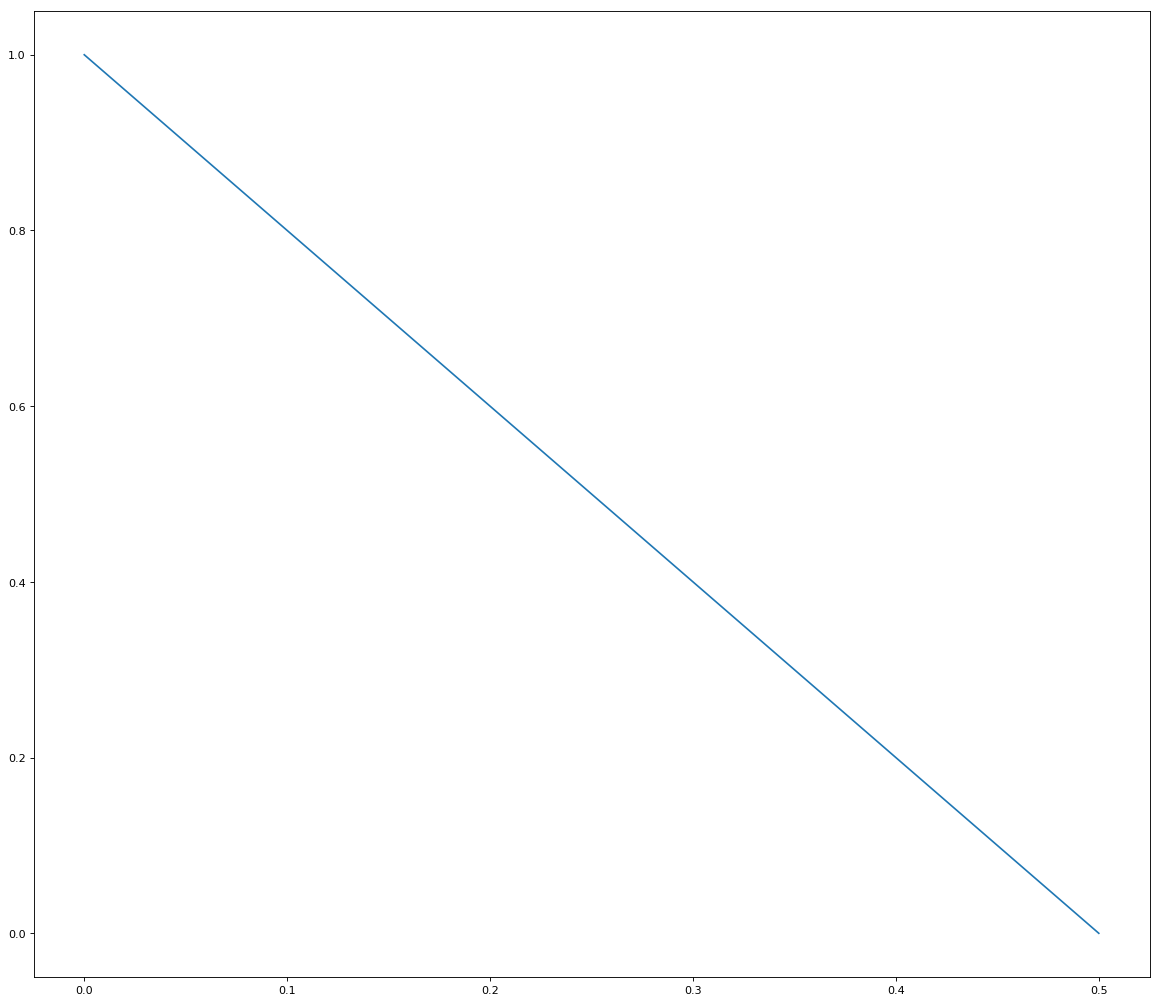

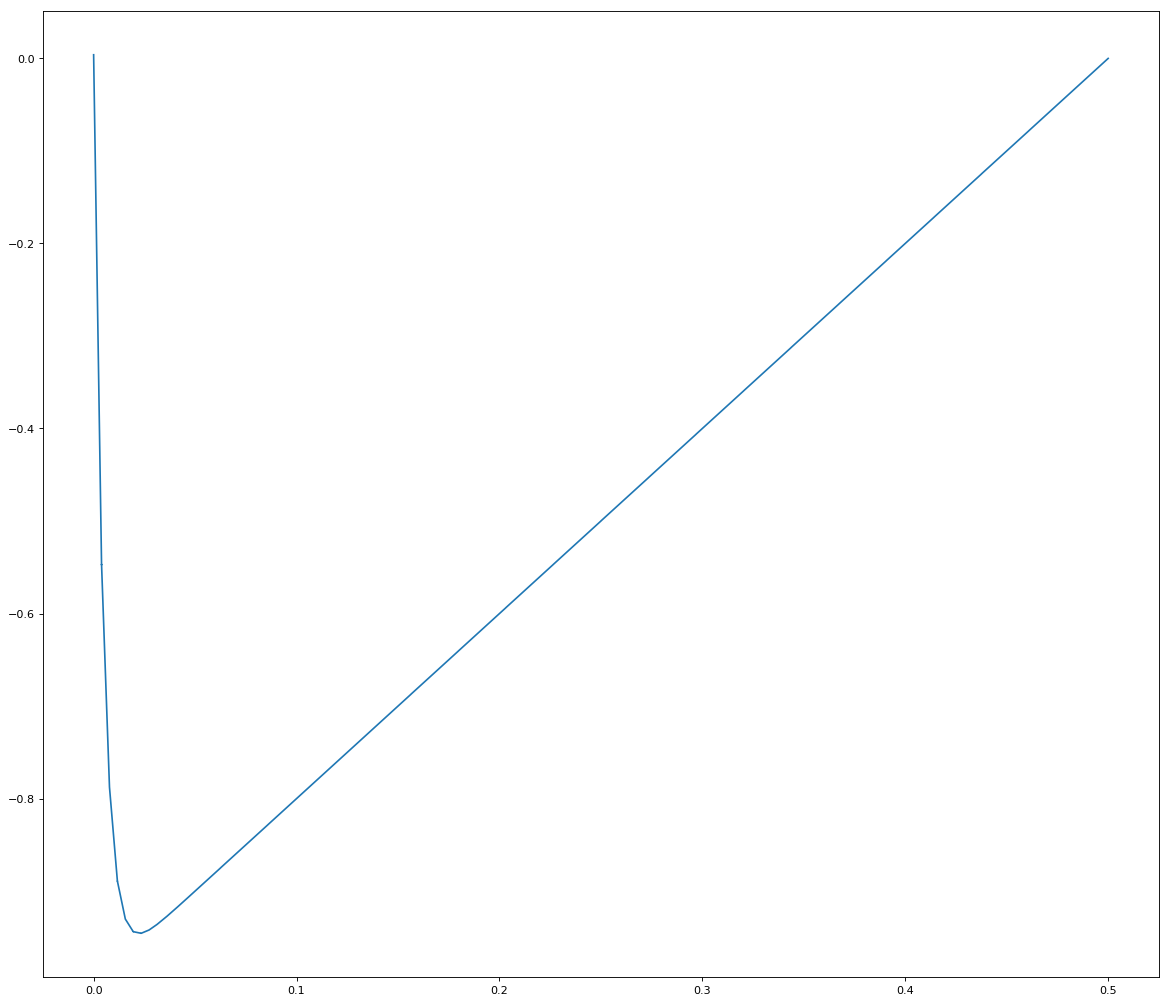

<Figure size 432x288 with 0 Axes>

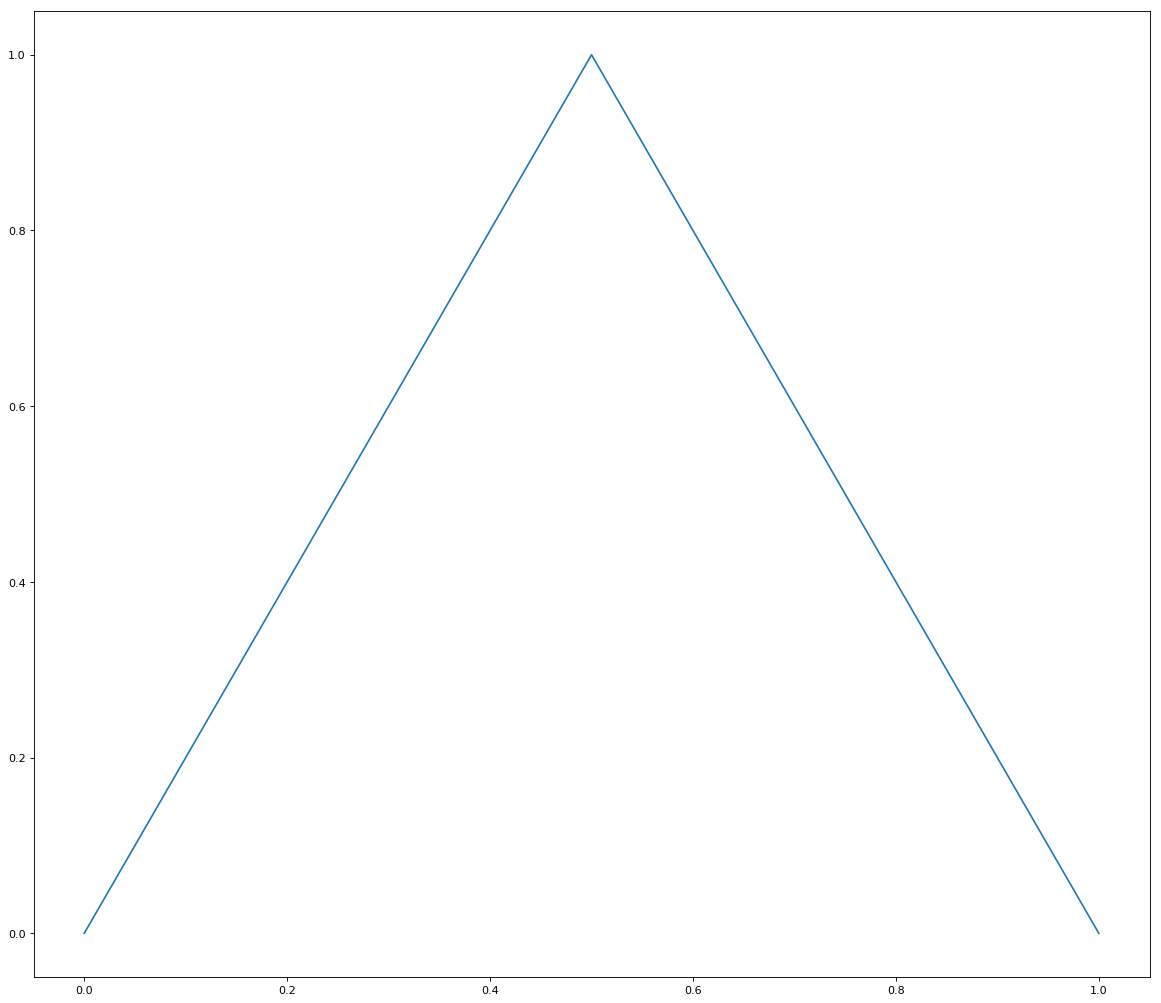

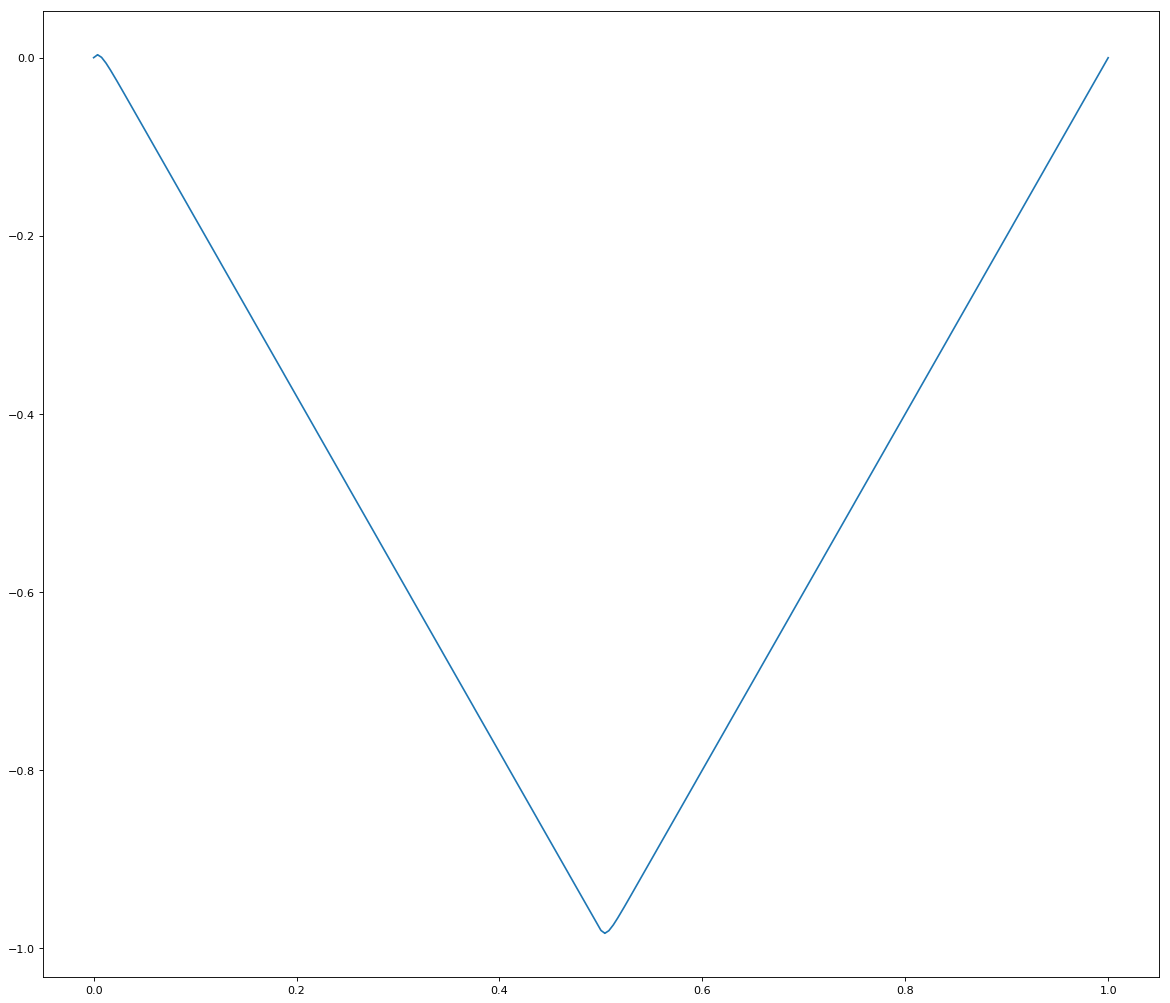

<Figure size 432x288 with 0 Axes>

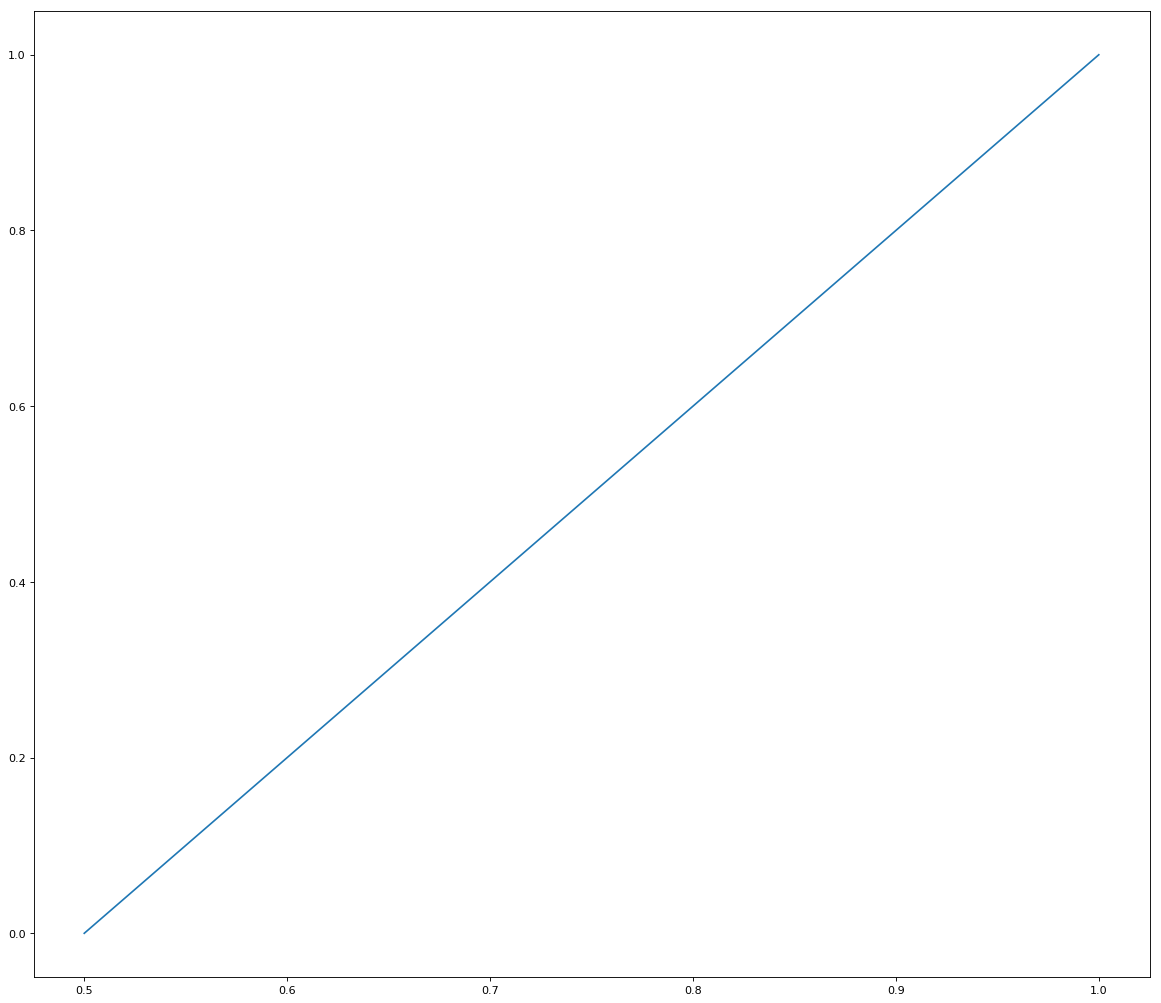

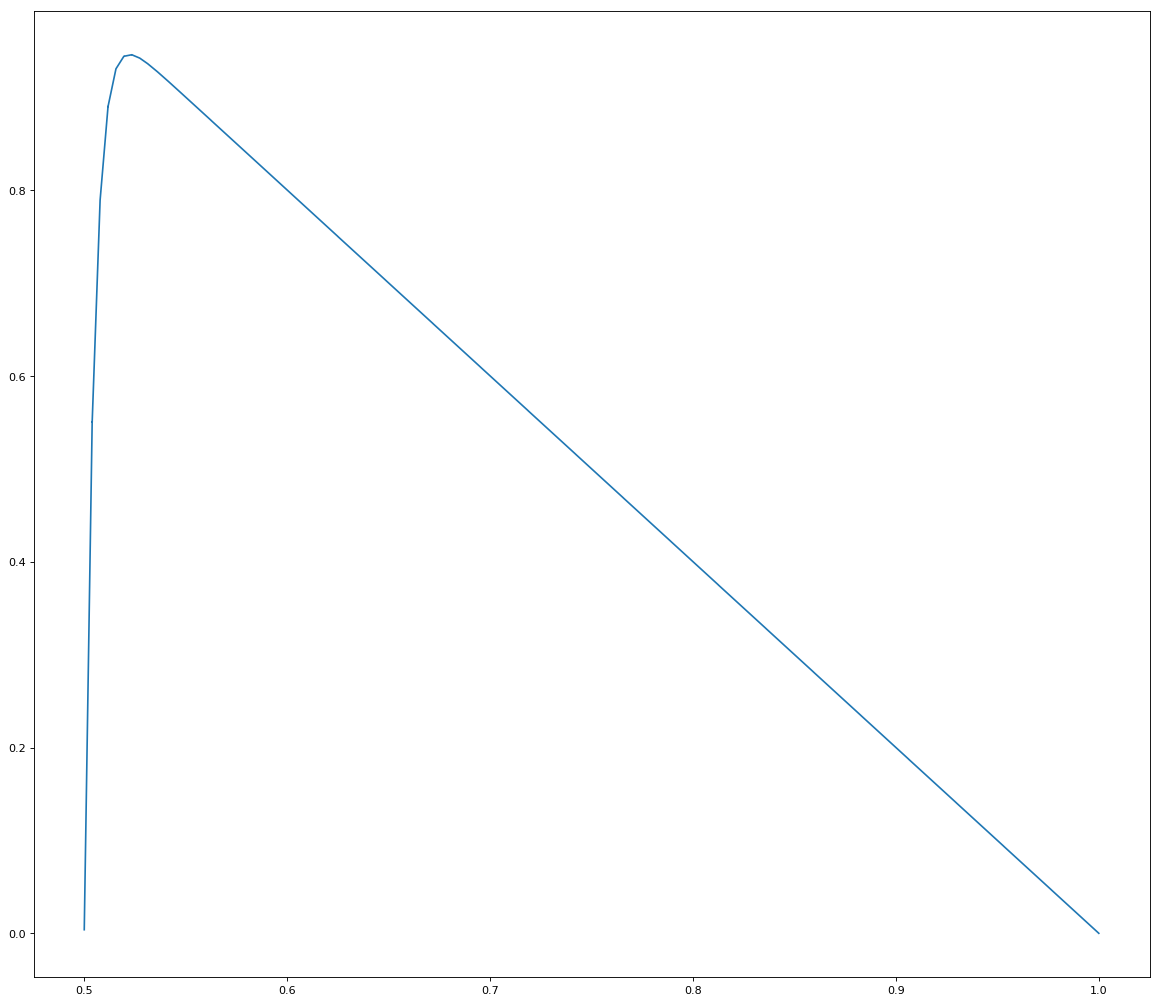

In [6]:
# Loop over all primal basis functions (nodes for FE).
for i in range(0, nr_nodes):
    # Create topology and geometry
    lower, upper, elems, node_nr = support(i, primalDegree, primalNelems, lbound, primalspan)
    print(lower, upper, elems, node_nr)
    localPrimalDomain, localGeom = mesh.rectilinear([numpy.linspace(lower, upper, elems+1)]*ndims)
    # Important step to restrict refinement to adjoint domain only
    #localDomain = localPrimalDomain
    localDomain = deepcopy(localPrimalDomain)
    #localDomain, junk = mesh.rectilinear([numpy.linspace(lower, upper, elems+1)]*ndims)
    for k in range(0, adjointNelems -1):
        tempDomain = localDomain
        localDomain = tempDomain.refined
    print('Number of refinement steps: %s' % (localDomain.nrefine))
    
    # Put geometry in namespace
    ns.x = localGeom
    # Create local bases
    #     Primal
    ns.primalBasis = localPrimalDomain.basis('lagrange', degree=primalDegree)                 # corresponds to phi
    #     Adjoint
    ns.adjointBasis = localDomain.basis('discont', degree=(primalDegree*adjointDegree)) # corresponds to psi
    
    # Build adjoint solution function
    ns.uAdj = 'adjointBasis_n ?lhsAdj_n'
    
    # Format primal basis function string (pbs) for integral expressions
    #     without derivative
    pbs    = 'primalBasis_%s'   % (node_nr)
    print('PBS is %s' % pbs)
    pbsDer = 'primalBasis_%s,0' % (node_nr)
    print('PBS is %s' % pbsDer)
    
    
    
    ####################################################################
    ###################### construct residual ##########################
    #-------------------------------------------------------------------
    # Element integrals
    # Diffusive part and RHS
    resAdj = localDomain.integral('k adjointBasis_n,0 uAdj_,0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    resAdj += localDomain.integral('-v adjointBasis_n,0 uAdj' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part primal basis
    resAdj += localDomain.integral('-v adjointBasis_n,0 %s' % (pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # SUPG stabilized part (will be added later)
    # TODO: Check correctness of the SUPG part
    resAdj += localDomain.integral(' tau v adjointBasis_n,0 (k (uAdj_,0)_,0 + v (uAdj_,0 + %s) )' % (pbsDer) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    
    # Interface integrals
    if (adjointNelems > 1) or (elems > 1):
        # Diffusive part
        #    part one                      |
        #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
        resAdj += localDomain.interfaces.integral(' [adjointBasis_n] n_0 k {uAdj_,0} + beta k {adjointBasis_n,0} [uAdj] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        #    part two (stabilized)
        resAdj += localDomain.interfaces.integral(' tauA [adjointBasis_n] n_0 [uAdj] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        # Advective part perturbation
        resAdj += localDomain.interfaces.integral('- v [adjointBasis_n] n_0 ({uAdj} - .5 C [uAdj] n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        # Advective part primal basis
        resAdj += localDomain.interfaces.integral('- v [adjointBasis_n] n_0 ({%s} - .5 C [%s] n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    else:
        # No interface integrals
        pass
        

    # Boundary integrals LHS
    #    part one
    resAdj += localDomain.boundary.integral('- k uAdj_,0 adjointBasis_n + beta k uAdj adjointBasis_n,0 ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #    part two (stabilized)
    resAdj += localDomain.boundary['left'].integral(' tauZero uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral(' tauN uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)

    # Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
    # Diffusive part (keep an eye on the signs)
    resAdj -= localDomain.boundary['left'].integral(' ( beta k adjointBasis_n,0 + tauZero adjointBasis_n) gl ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj -= localDomain.boundary['right'].integral(' ( beta k adjointBasis_n,0 + tauN adjointBasis_n) gr ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    resAdj += localDomain.boundary['left'].integral('v stab adjointBasis_n n_0 (0.5 (gl + uAdj) - .5 C (gl - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v stab adjointBasis_n n_0 (0.5 (gr + uAdj) - .5 C (gr - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part primal basis
    resAdj += localDomain.boundary['left'].integral('v stab adjointBasis_n n_0 (0.5 (gl + %s) - .5 C (gl - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    resAdj += localDomain.boundary['right'].integral('v stab adjointBasis_n n_0 (0.5 (gr + %s) - .5 C (gr - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #-------------------------------------------------------------------
    ###################### construct residual ##########################
    ####################################################################
    
    
    # Solve system
    # find lhs such that res == 0 and substitute this lhs in the namespace
    # lhs = solver.solve_linear('lhs', res, constrain=cons)
    lhsAdj = solver.solve_linear('lhsAdj', resAdj)
    ns = ns(lhsAdj=lhsAdj)
    
    ns.testPlot = '%s' % pbs
    
    # plot results
    # primal basis function
    plt.figure()
    bezier = localDomain.sample('bezier', 9)
    x, testPlot = bezier.eval([ns.x, ns.testPlot])
    #x, testPlot = bezier.eval([ns.x, ns.testPlot])
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    print('The following figure shows the primal Basis function: %s' % (pbs))
    plt.plot(x, testPlot)
    
    # perturbation
    #pltr.figure()
    bezier = localDomain.sample('bezier', 9)
    x, uAdj = bezier.eval([ns.x, ns.uAdj])
    #x, testPlot = bezier.eval([ns.x, ns.testPlot])
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    print('The following figure shows the respective perturbation function.')
    plt.plot(x, uAdj)
    

0 0.5 1 0
FineBasis


/home/slukic/Coding/Python/nutils/nutils/warnings.py:30: NutilsWarning: using explicit inflation; this is usually a bug.
  warnings.warn(message, category, stacklevel=stacklevel)


0.0 1.0 2 1
FineBasis


/home/slukic/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.5 1.0 1 1
FineBasis


<Figure size 432x288 with 0 Axes>

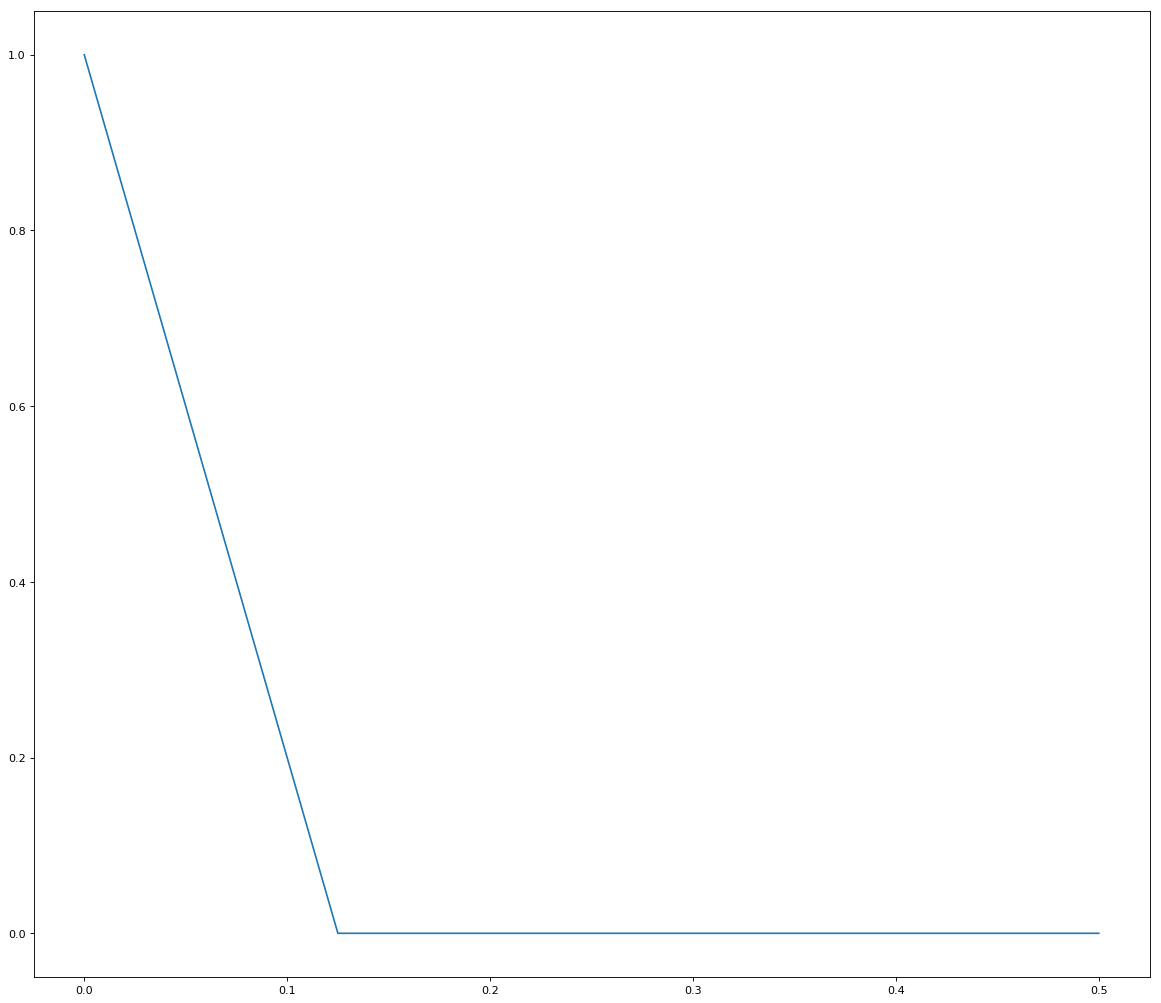

<Figure size 432x288 with 0 Axes>

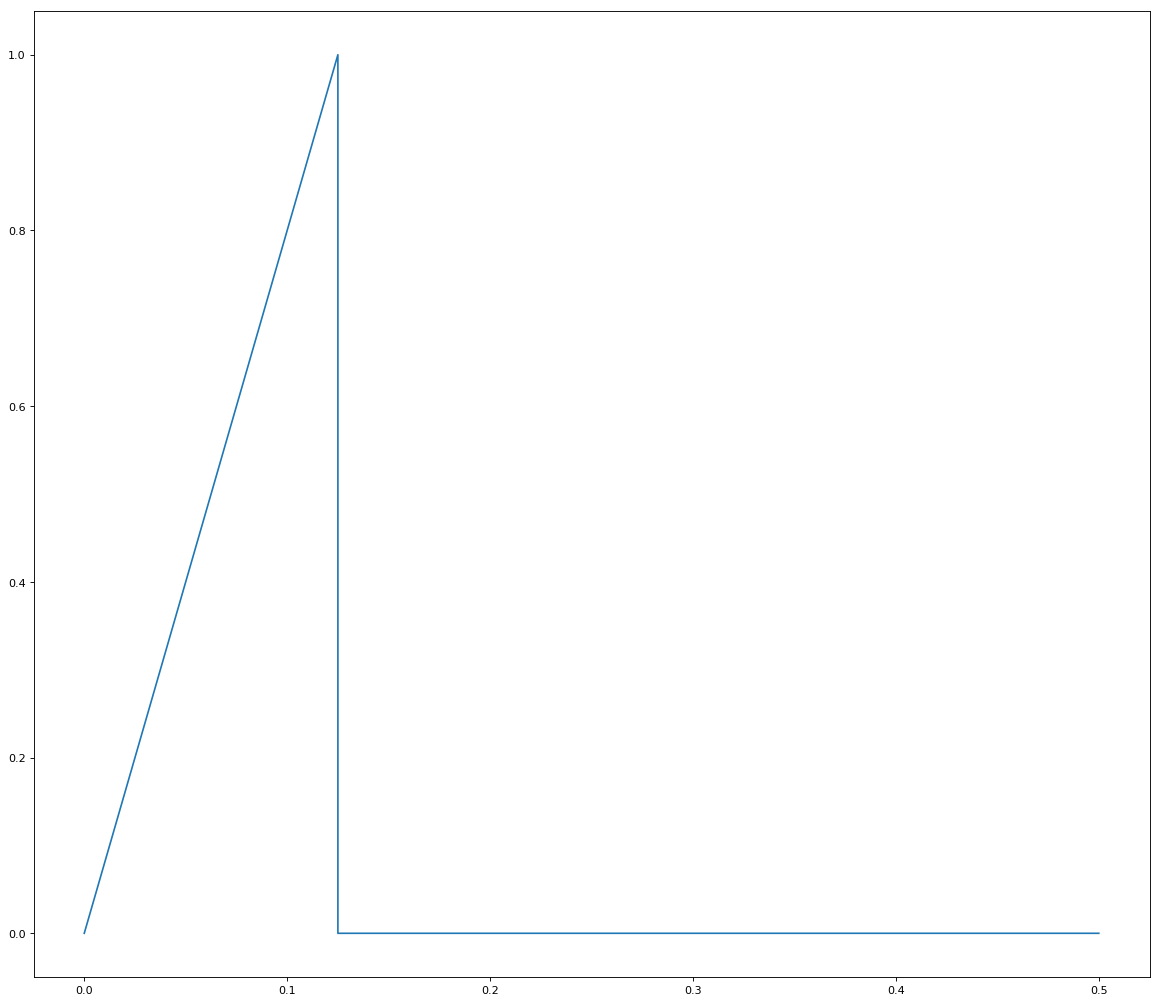

<Figure size 432x288 with 0 Axes>

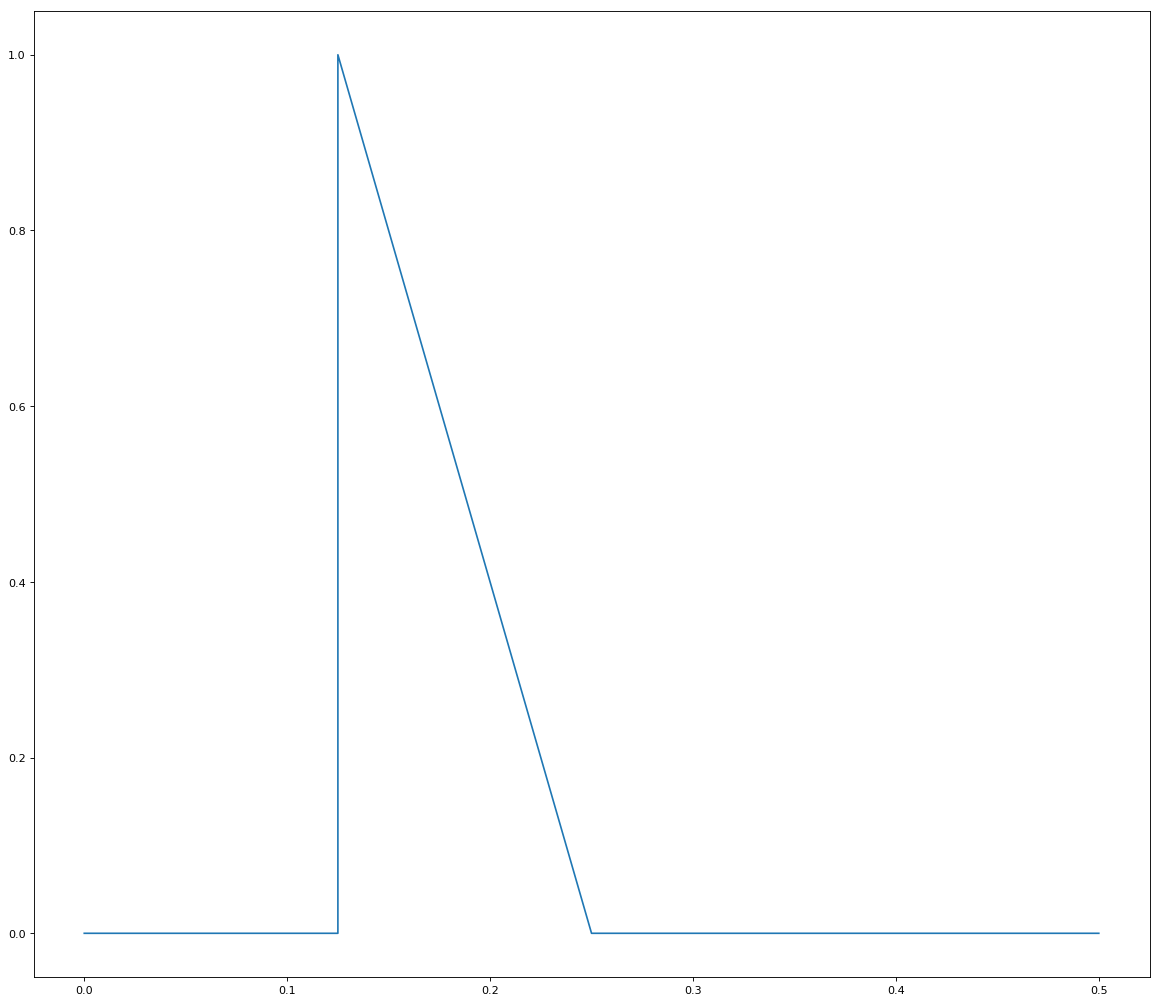

<Figure size 432x288 with 0 Axes>

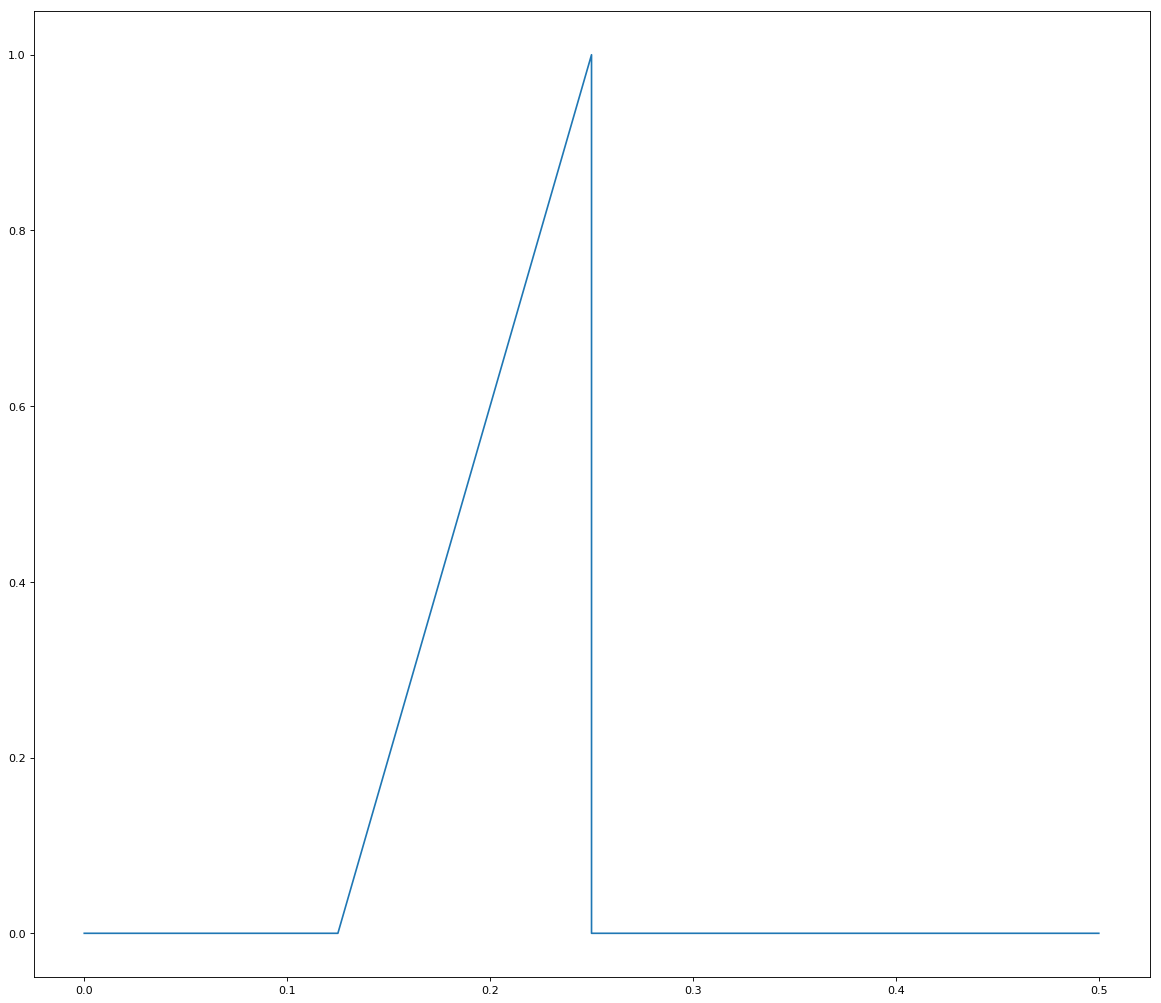

<Figure size 432x288 with 0 Axes>

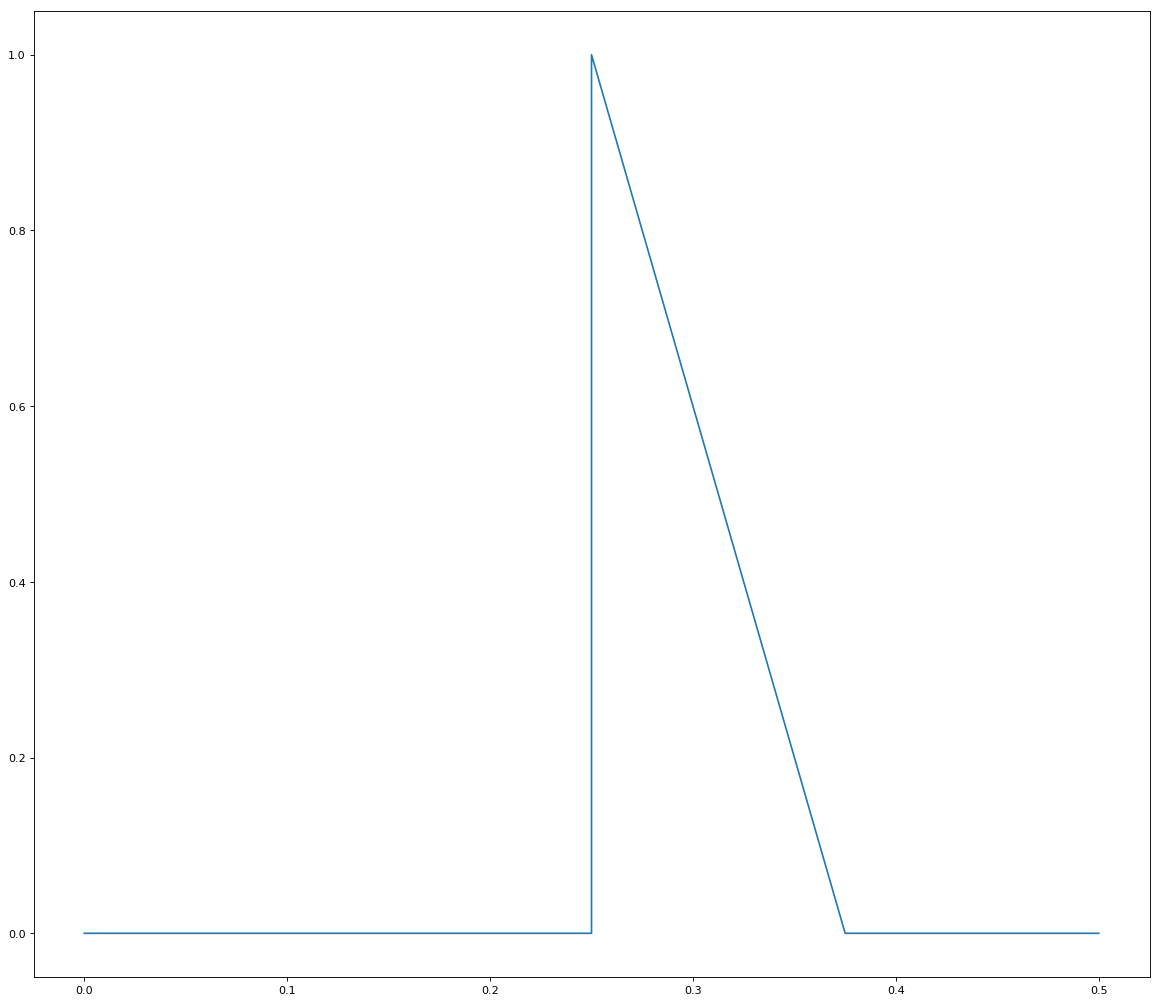

<Figure size 432x288 with 0 Axes>

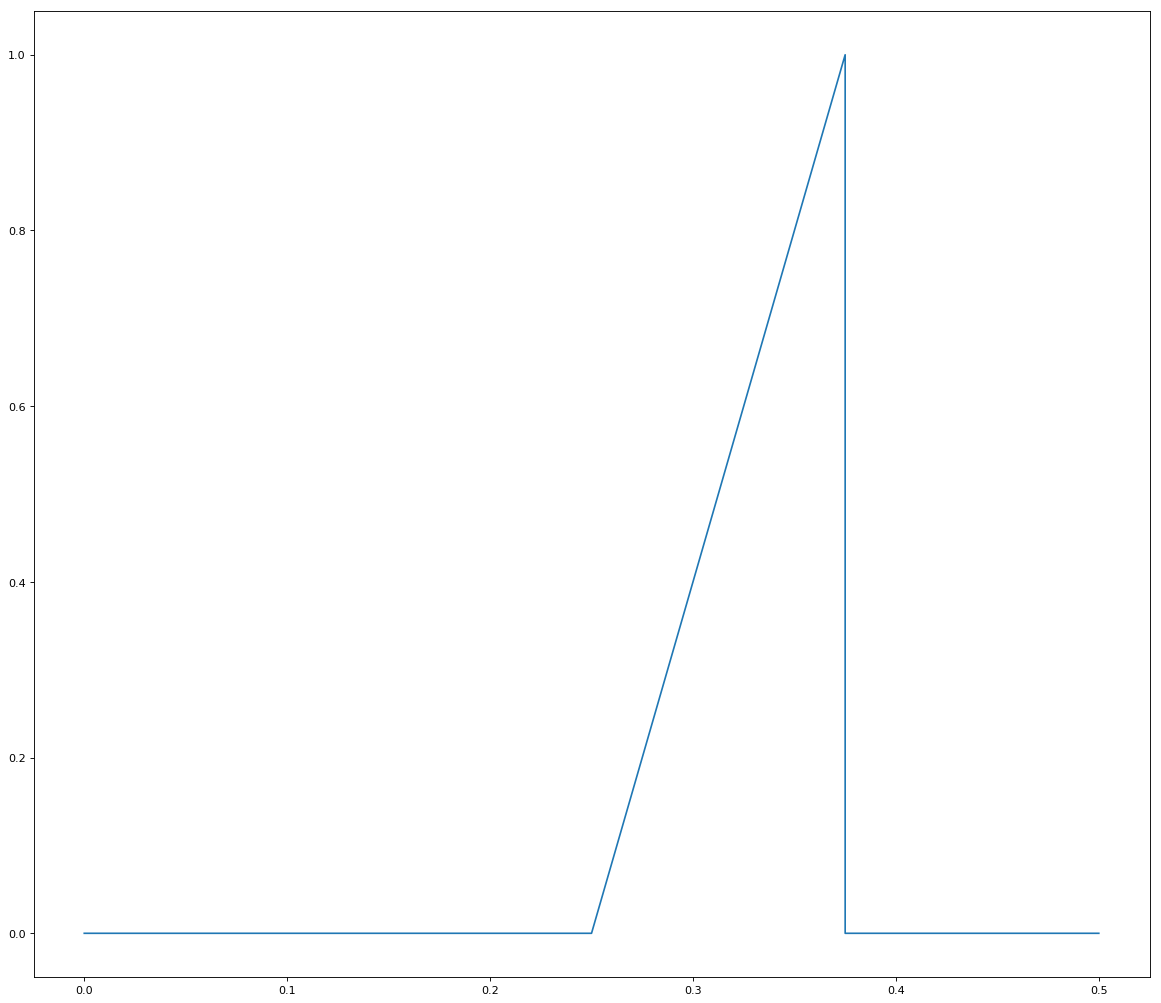

<Figure size 432x288 with 0 Axes>

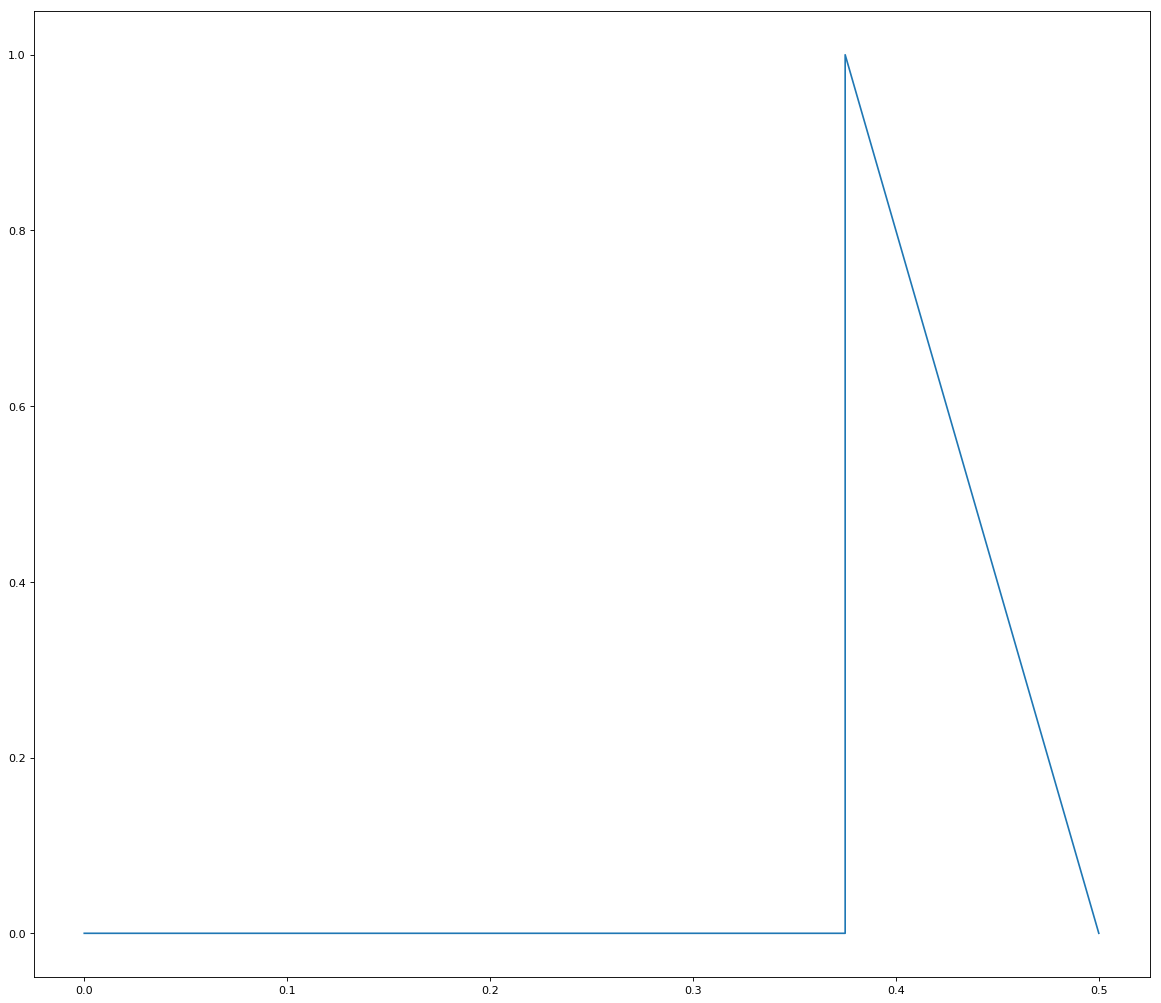

<Figure size 432x288 with 0 Axes>

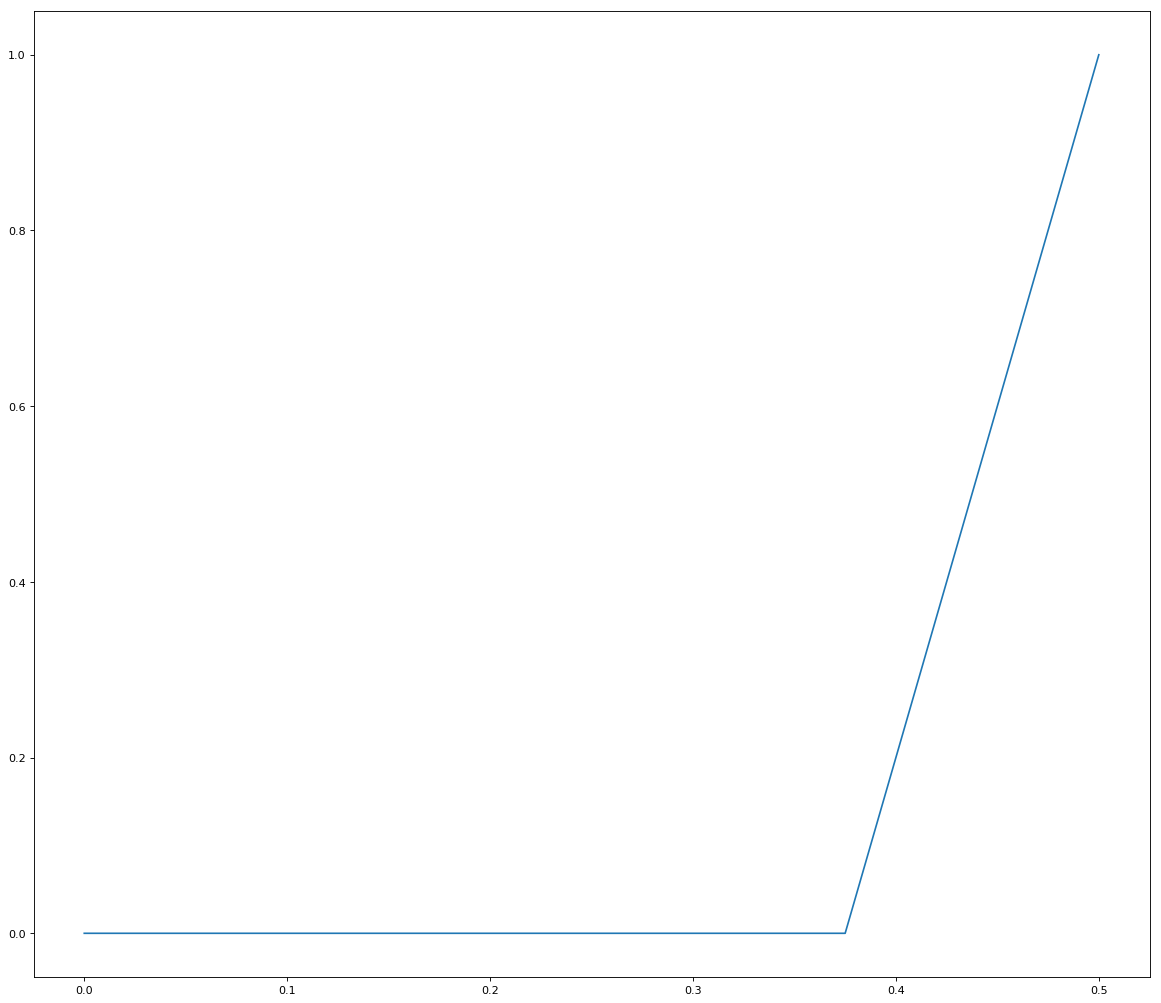

<Figure size 432x288 with 0 Axes>

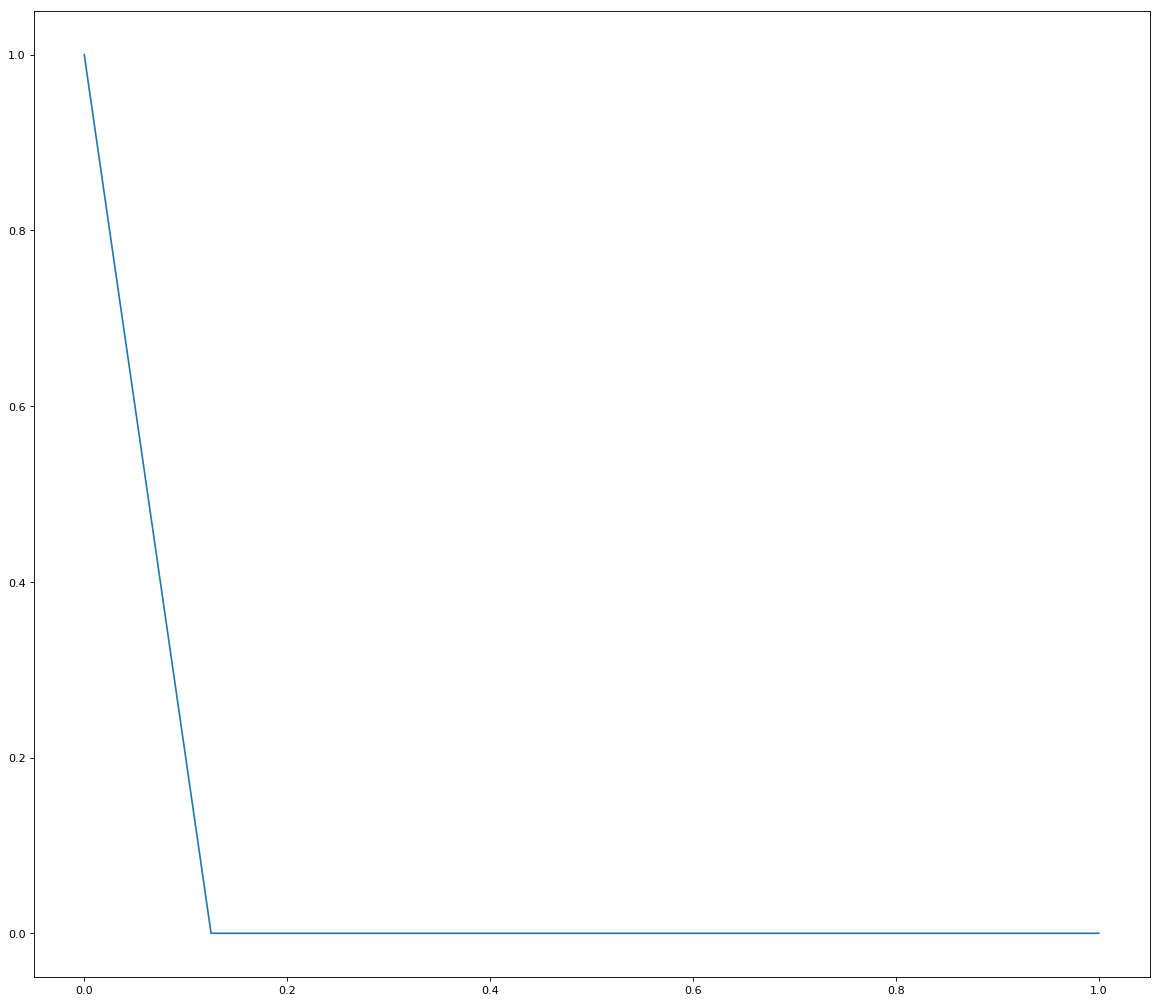

<Figure size 432x288 with 0 Axes>

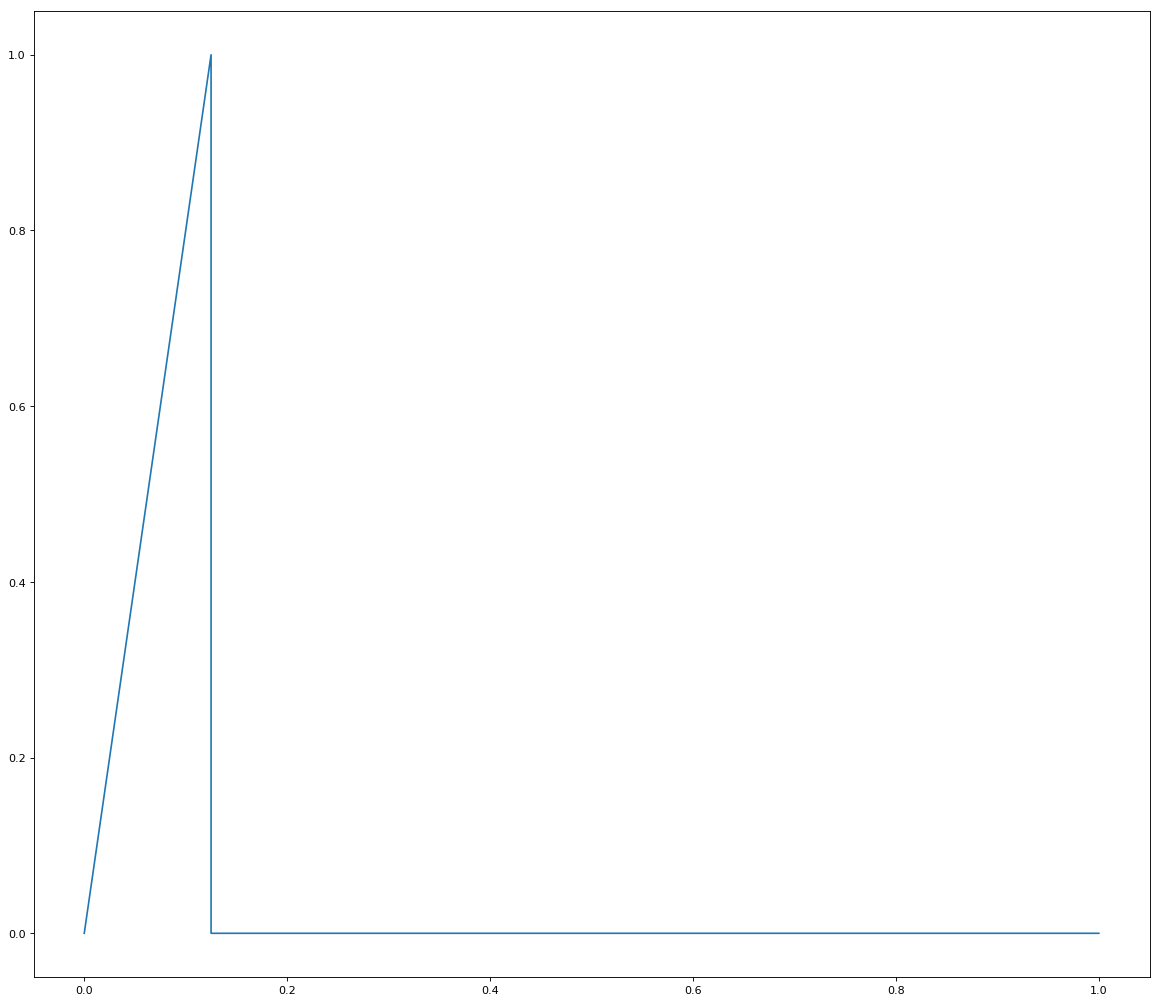

<Figure size 432x288 with 0 Axes>

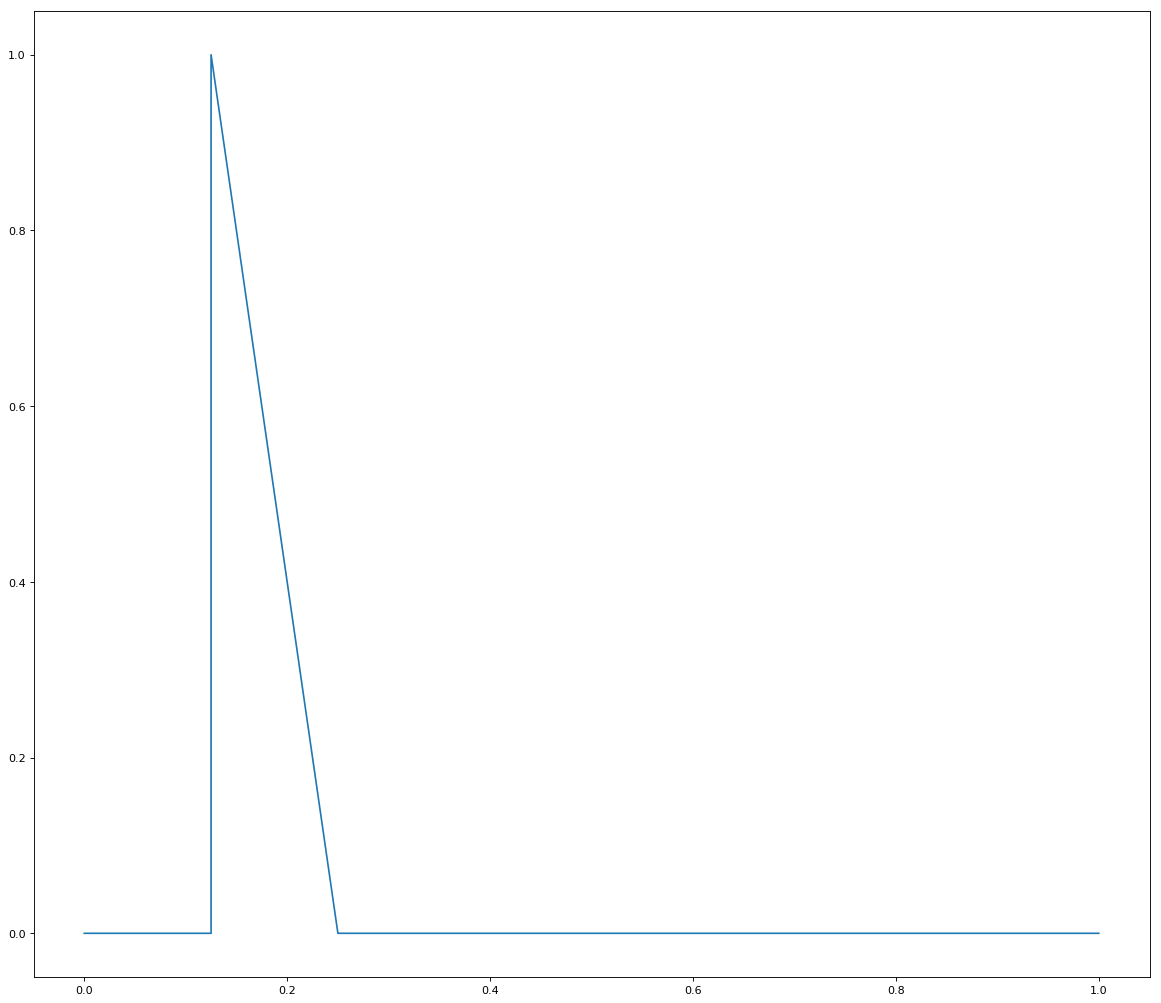

<Figure size 432x288 with 0 Axes>

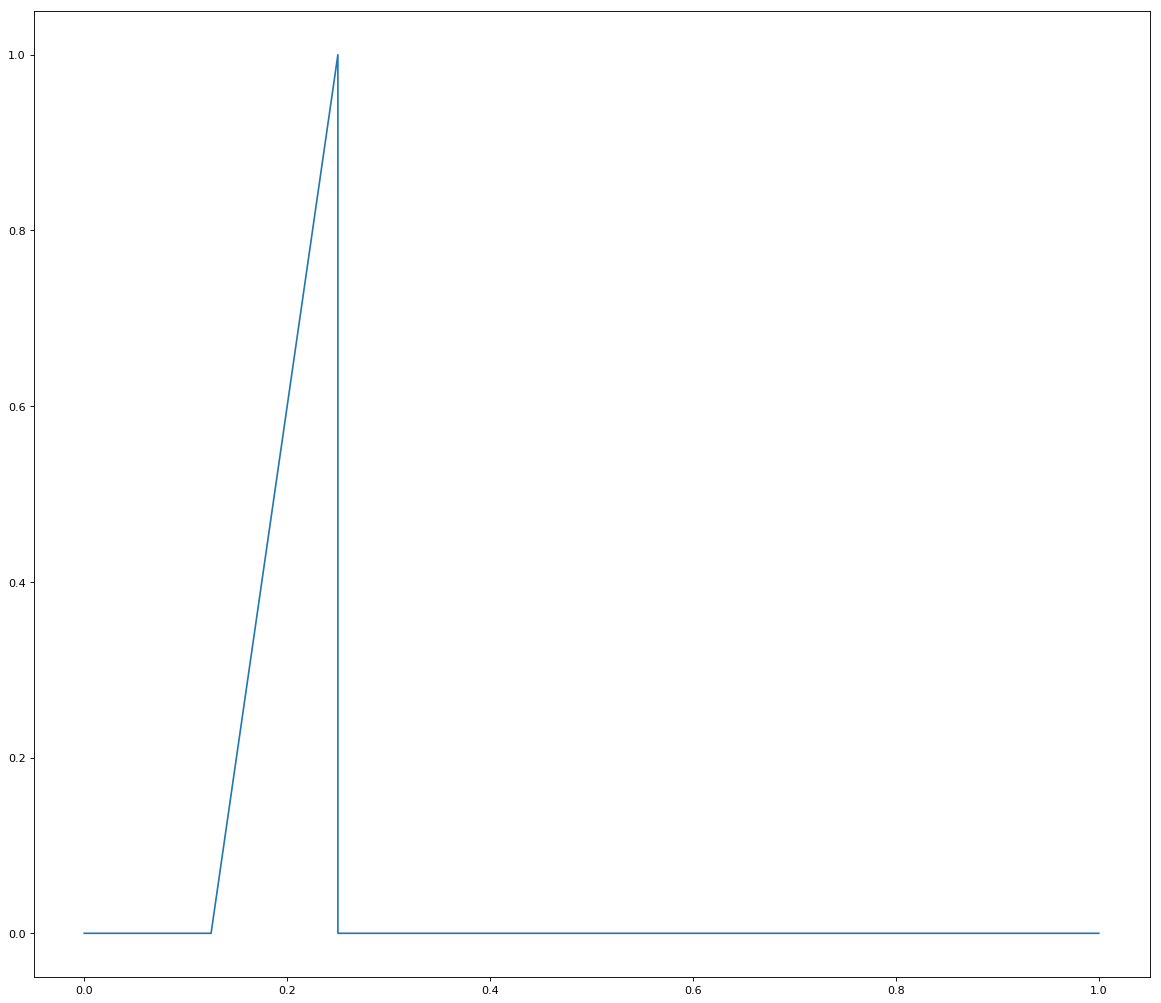

<Figure size 432x288 with 0 Axes>

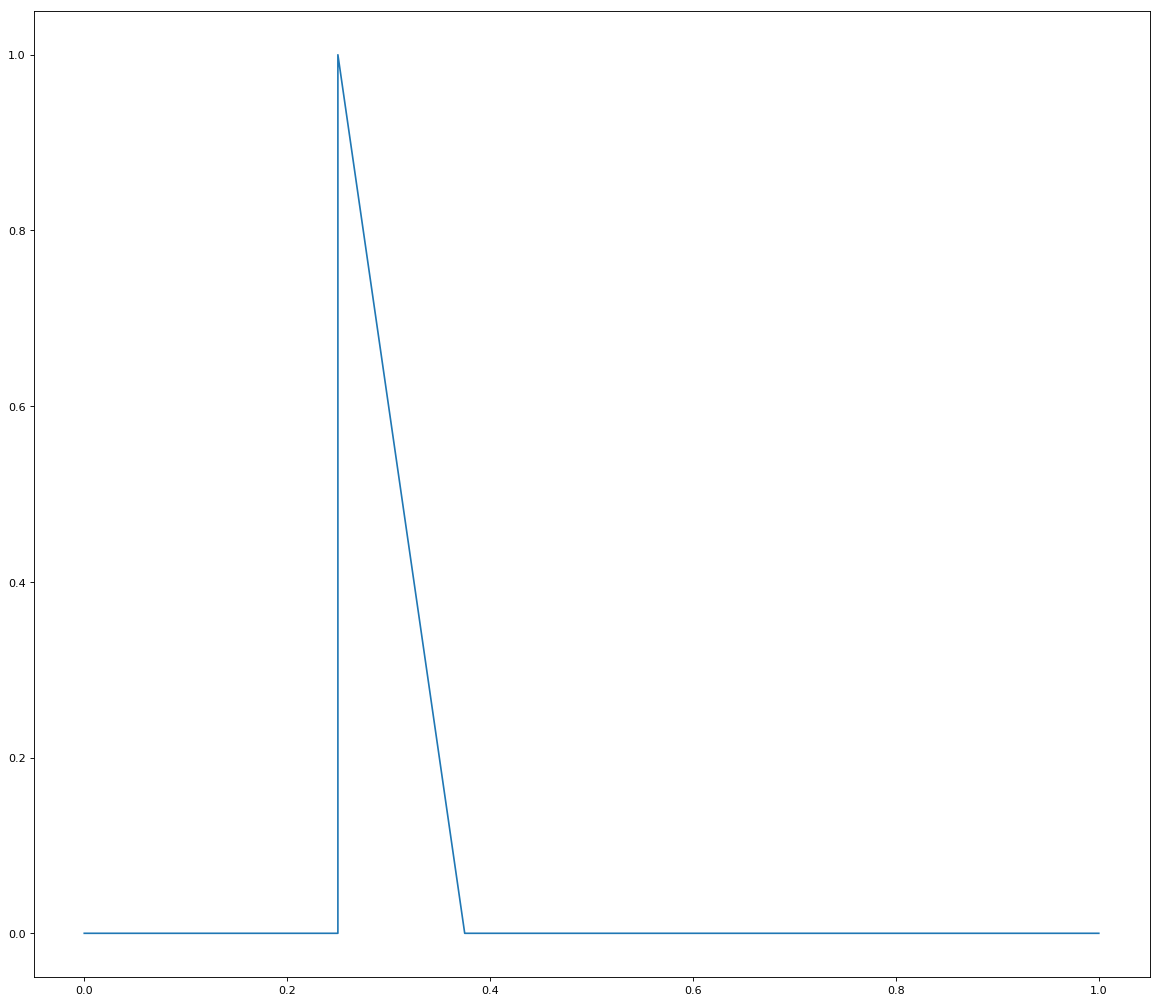

<Figure size 432x288 with 0 Axes>

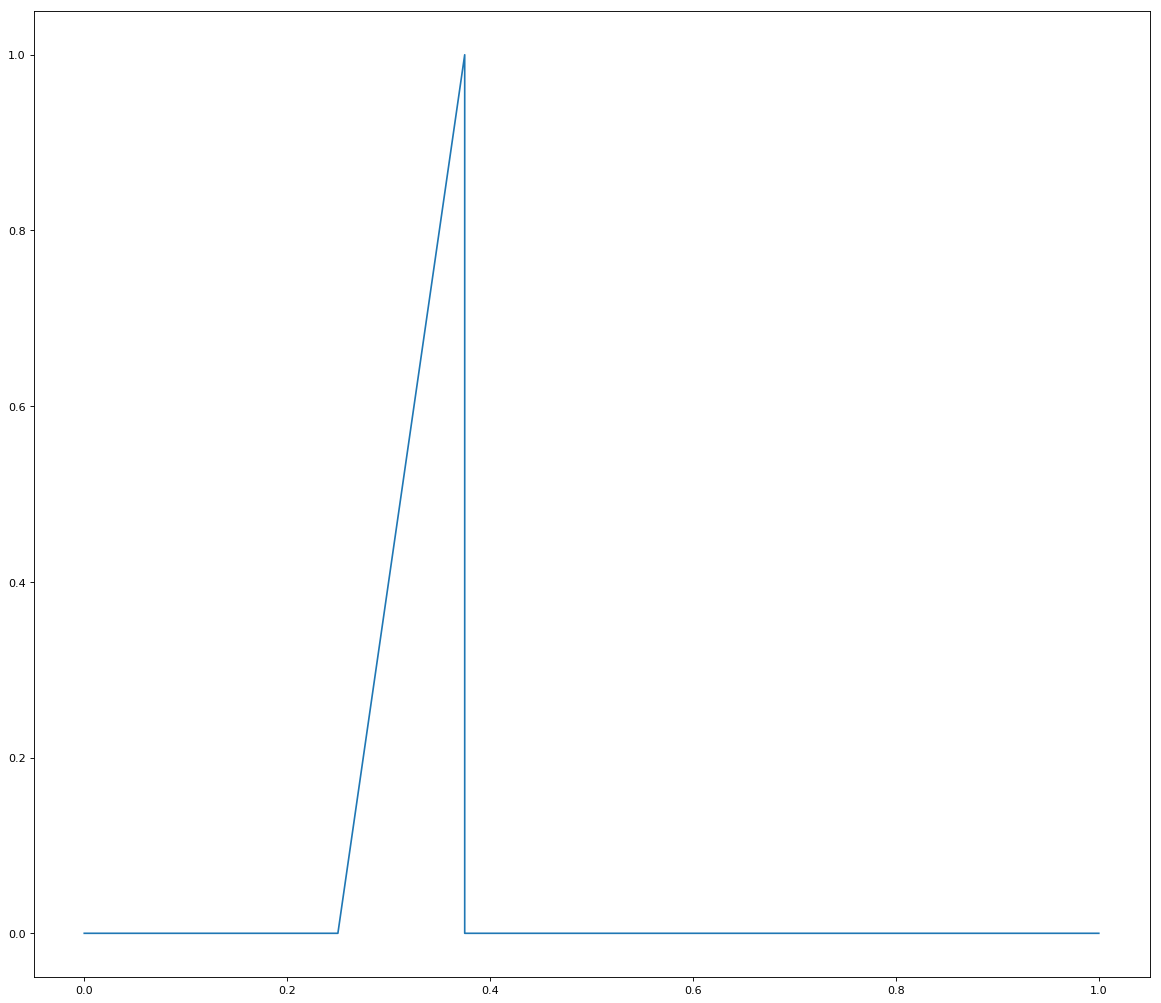

<Figure size 432x288 with 0 Axes>

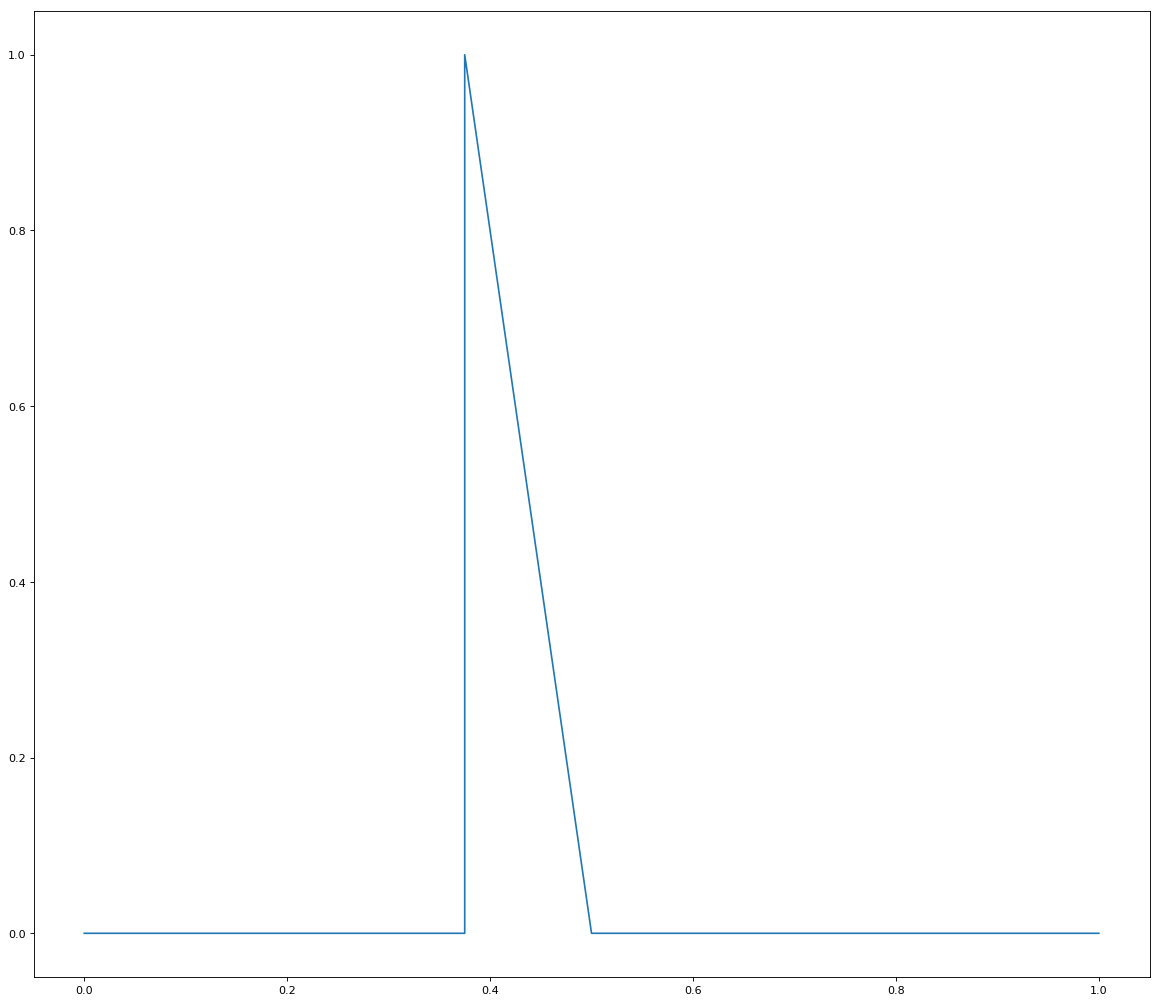

<Figure size 432x288 with 0 Axes>

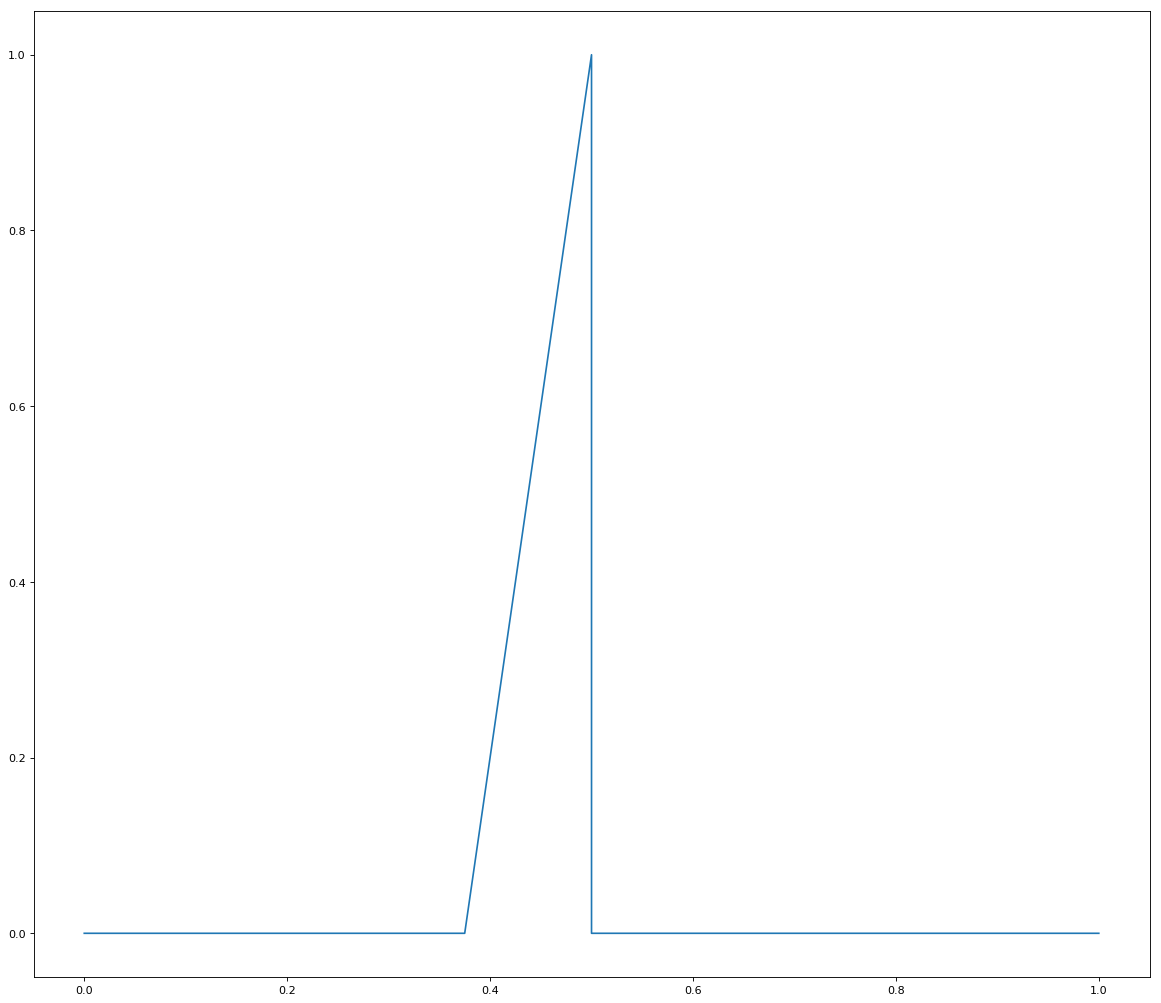

<Figure size 432x288 with 0 Axes>

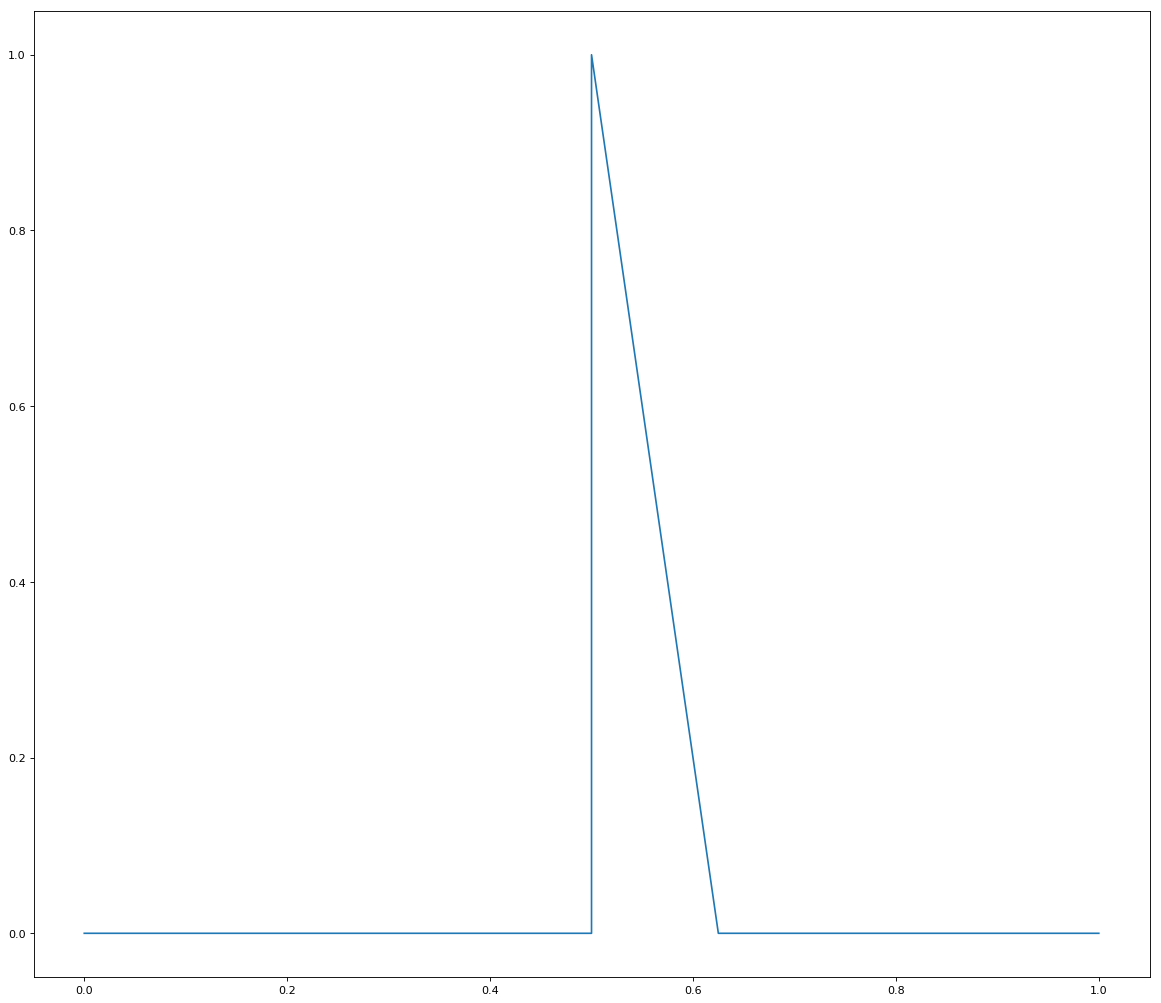

<Figure size 432x288 with 0 Axes>

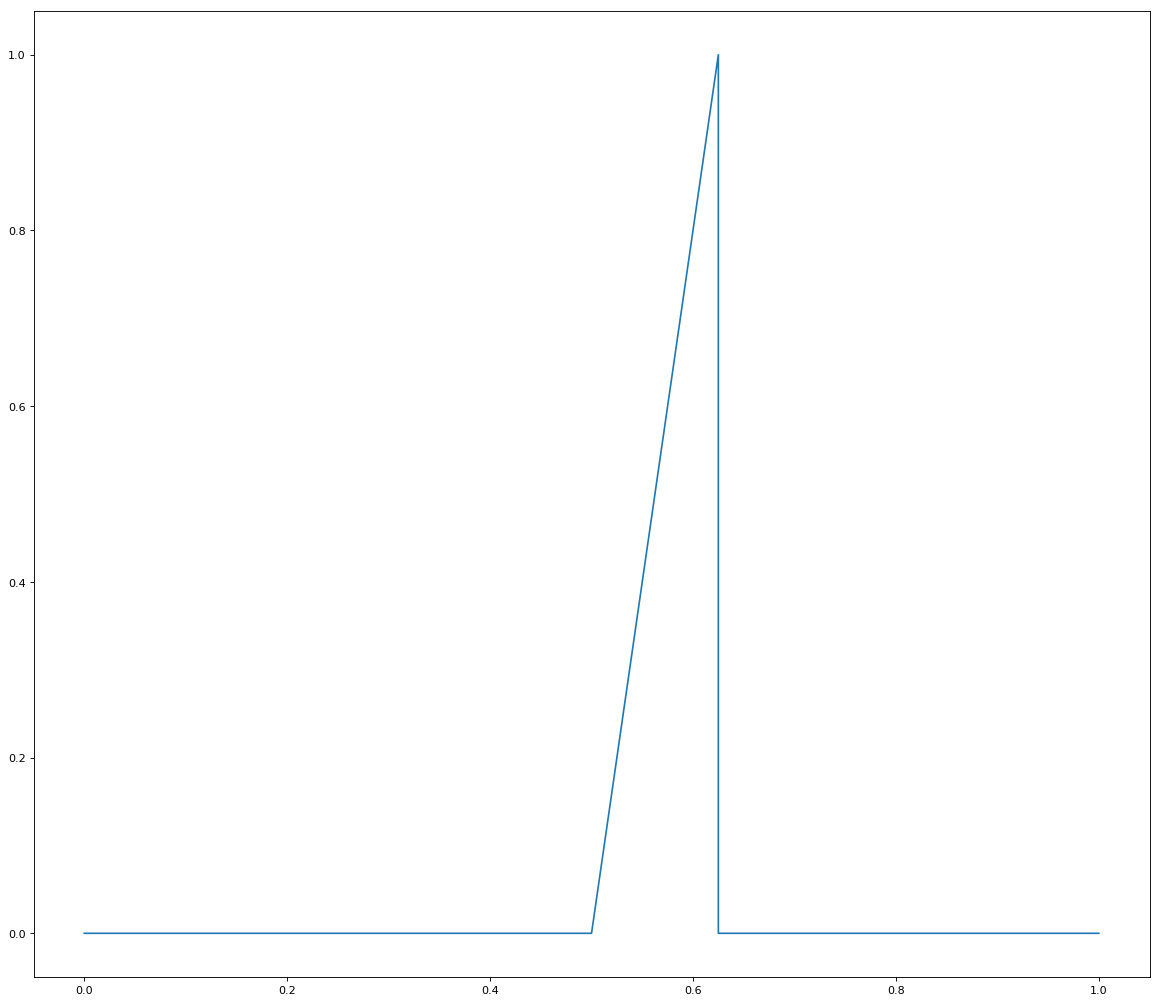

<Figure size 432x288 with 0 Axes>

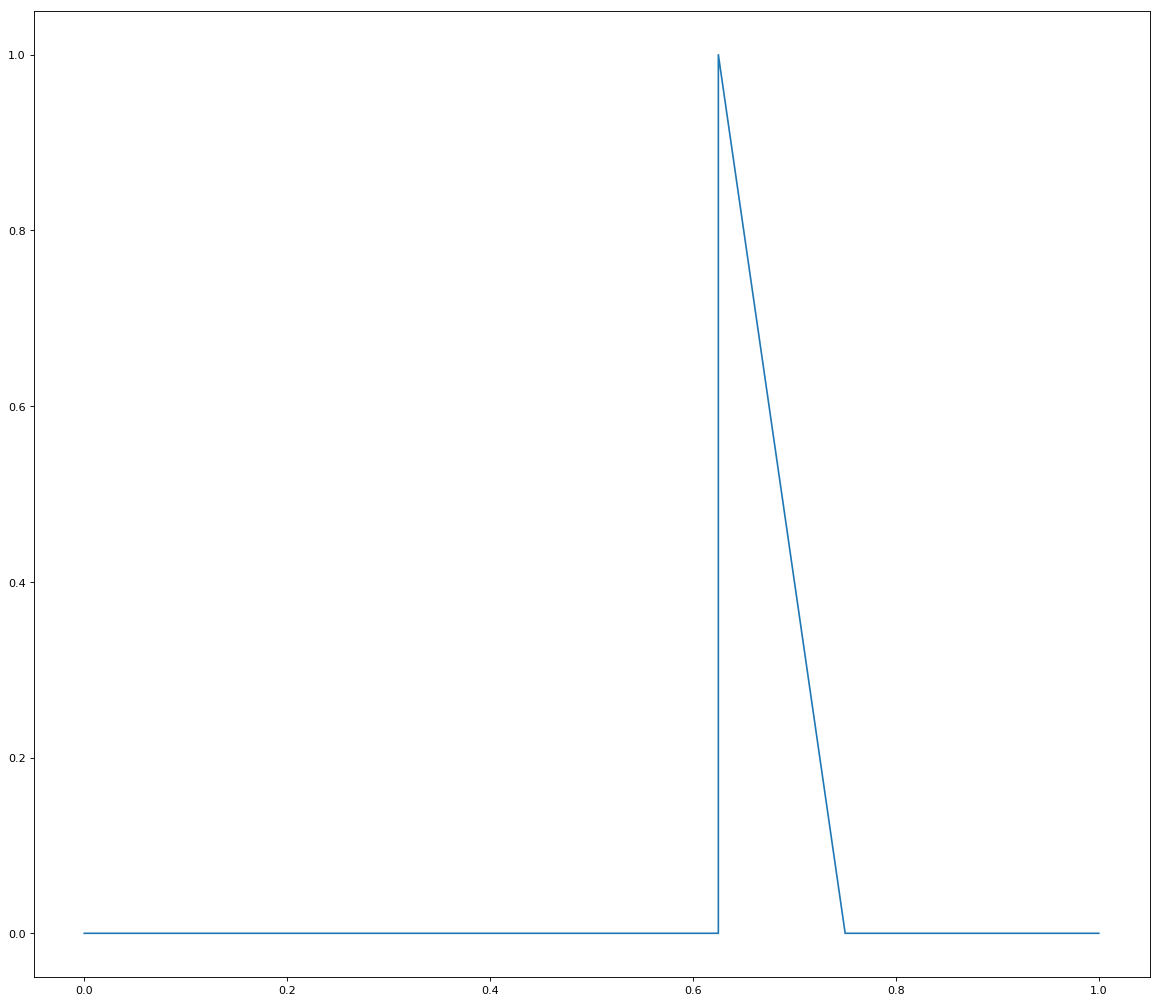

<Figure size 432x288 with 0 Axes>

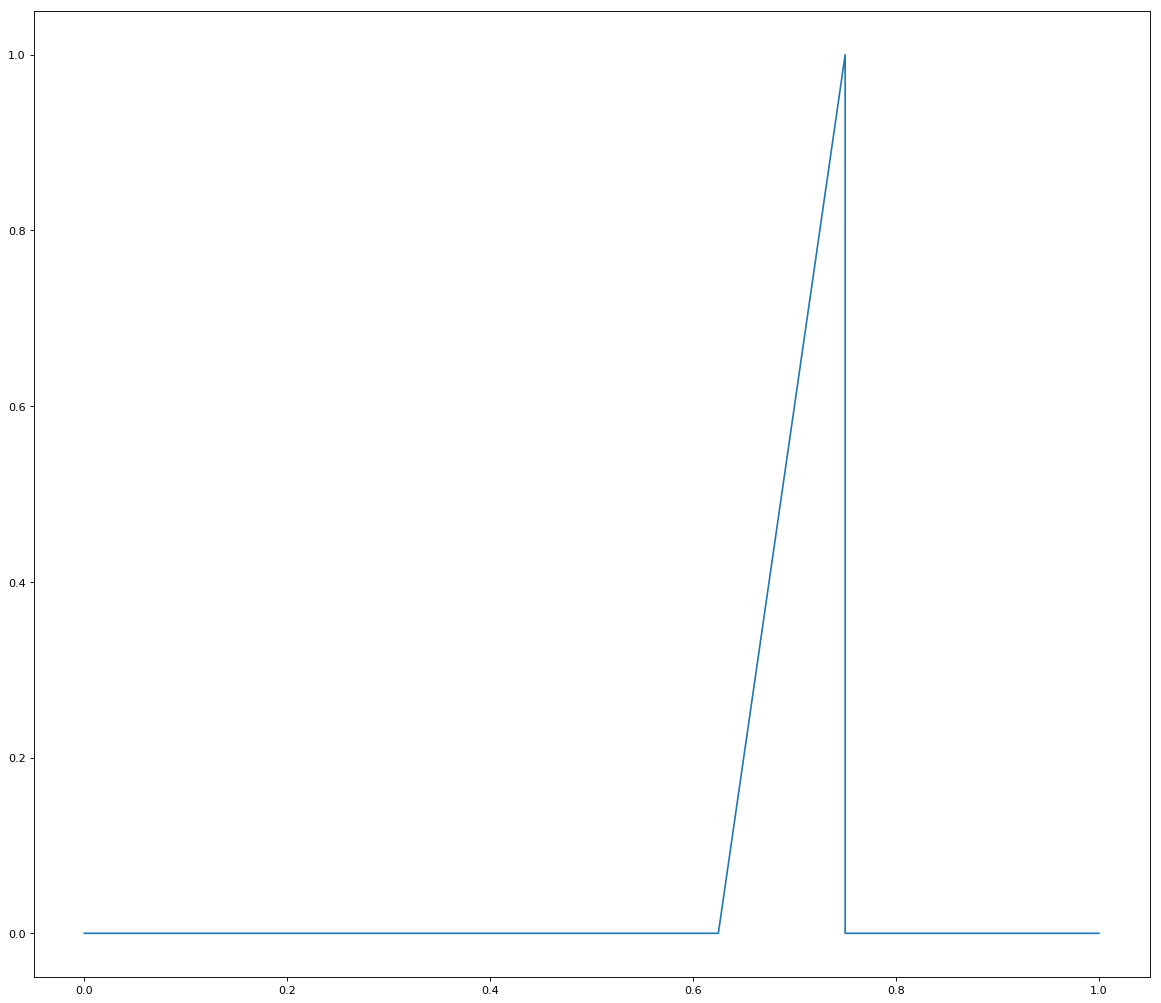

<Figure size 432x288 with 0 Axes>

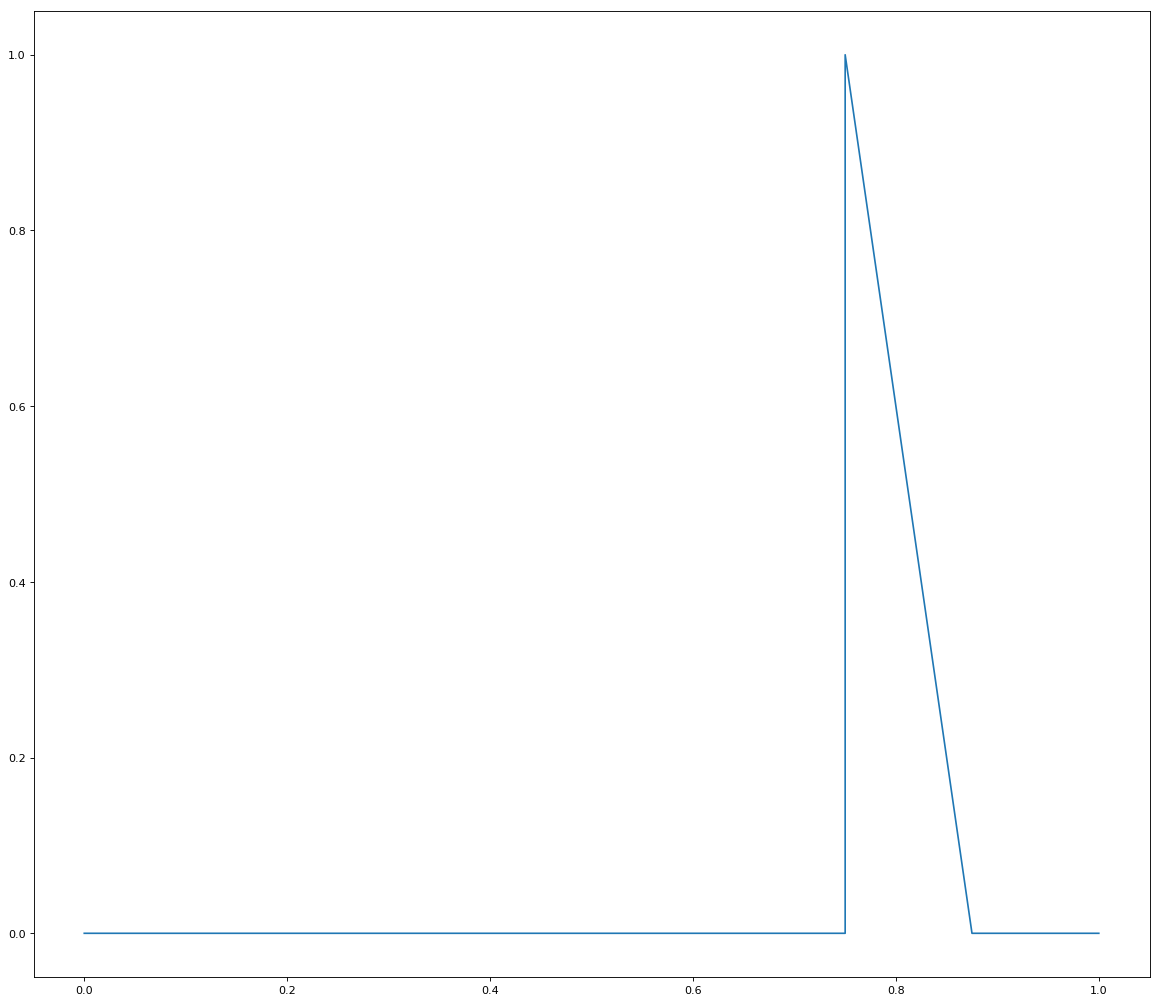

<Figure size 432x288 with 0 Axes>

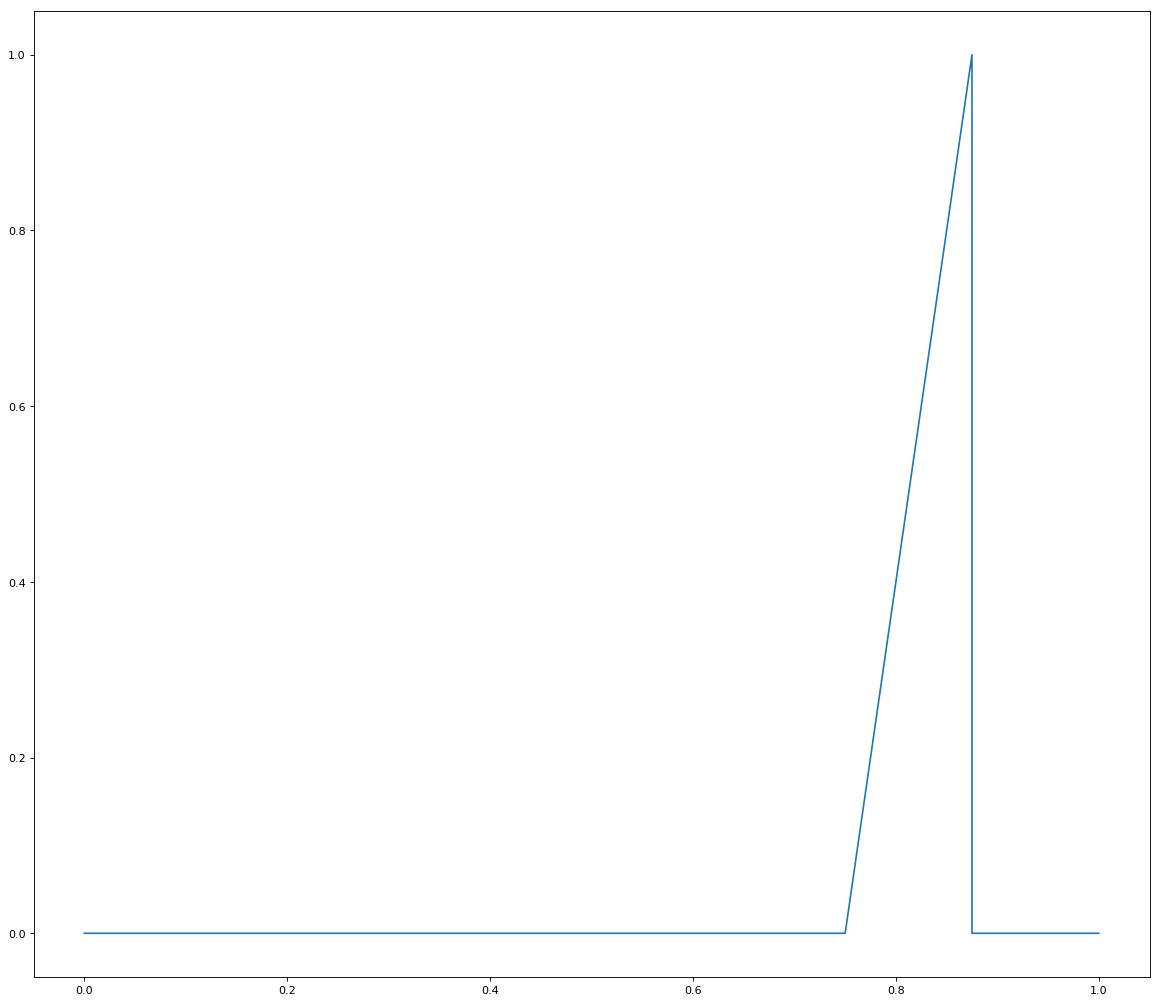

<Figure size 432x288 with 0 Axes>

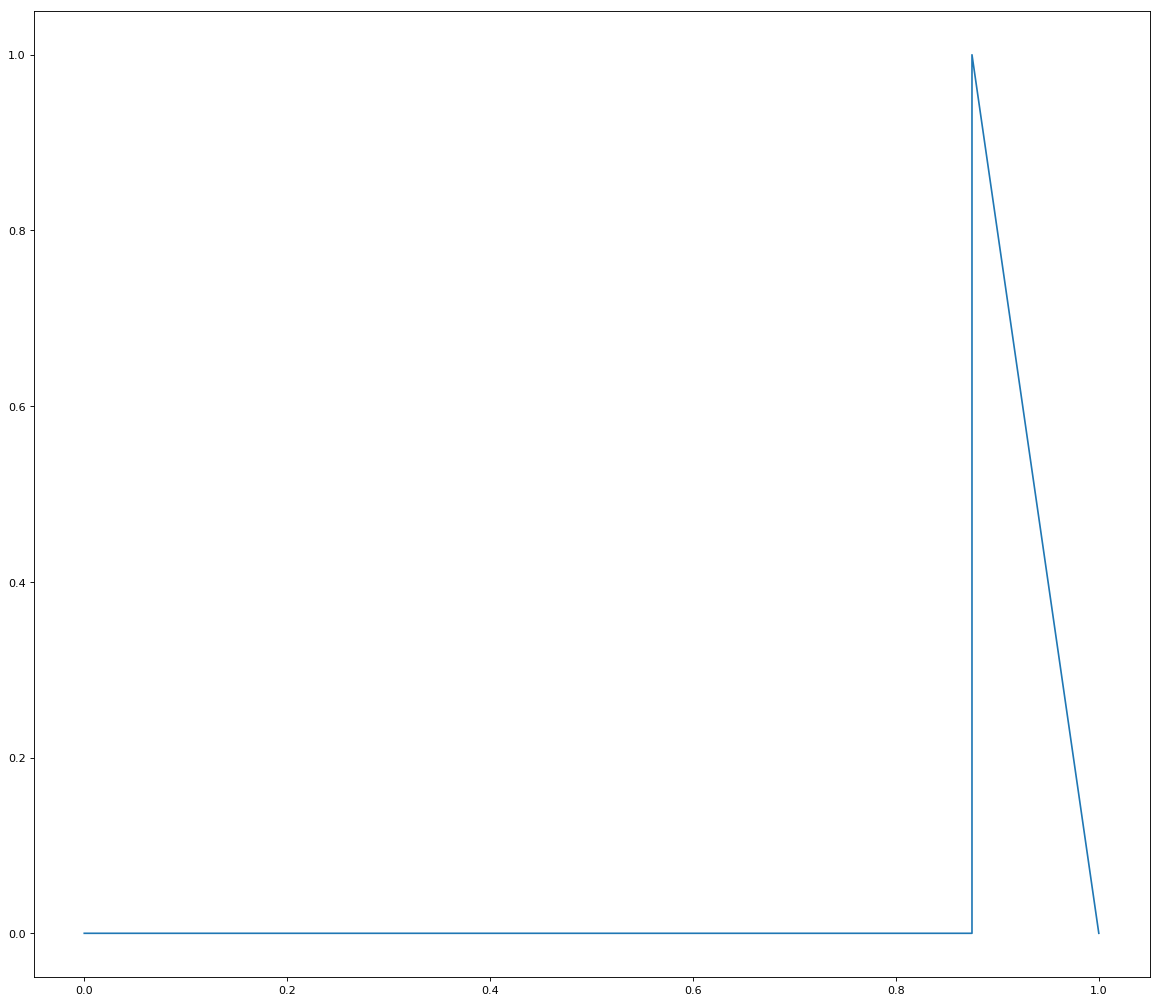

<Figure size 432x288 with 0 Axes>

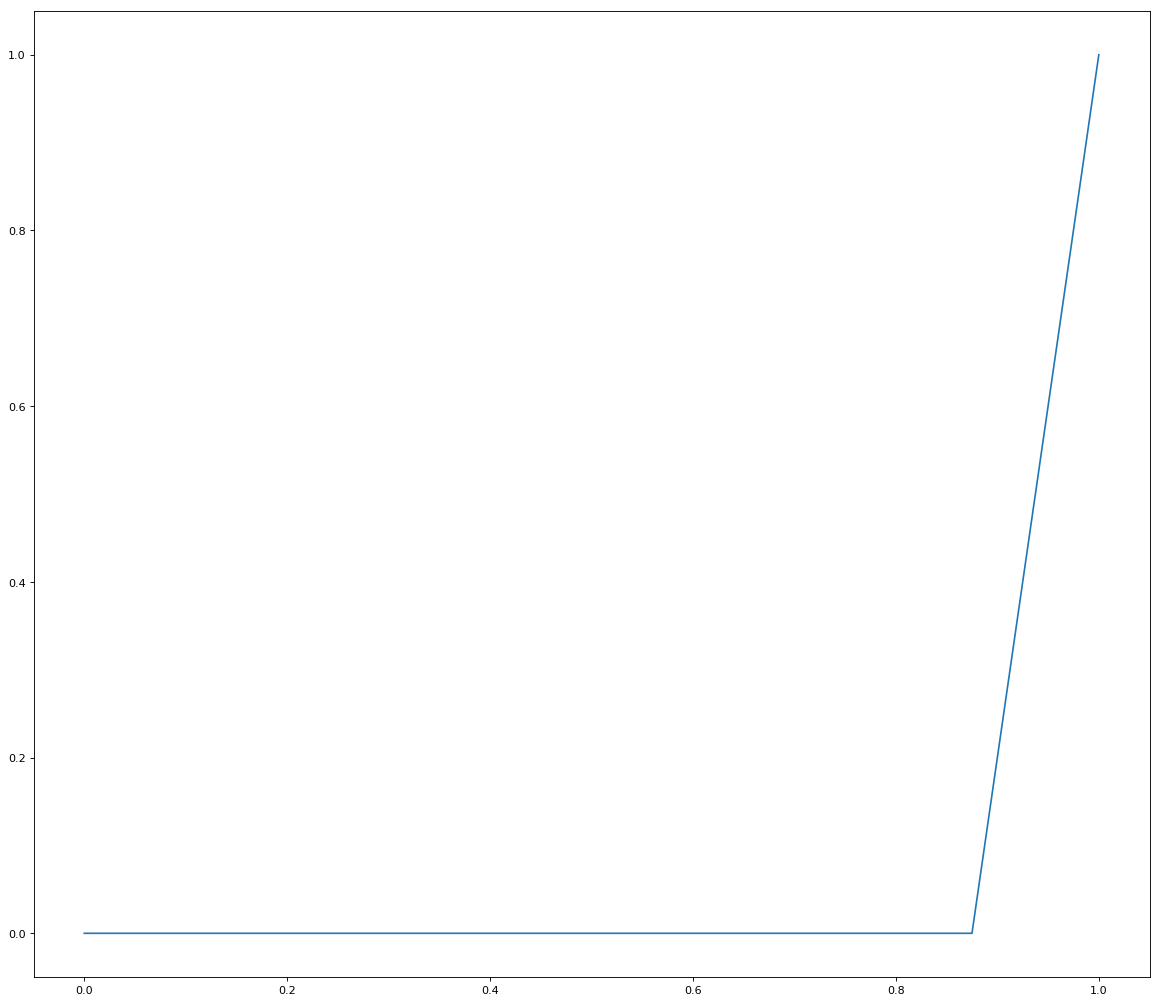

<Figure size 432x288 with 0 Axes>

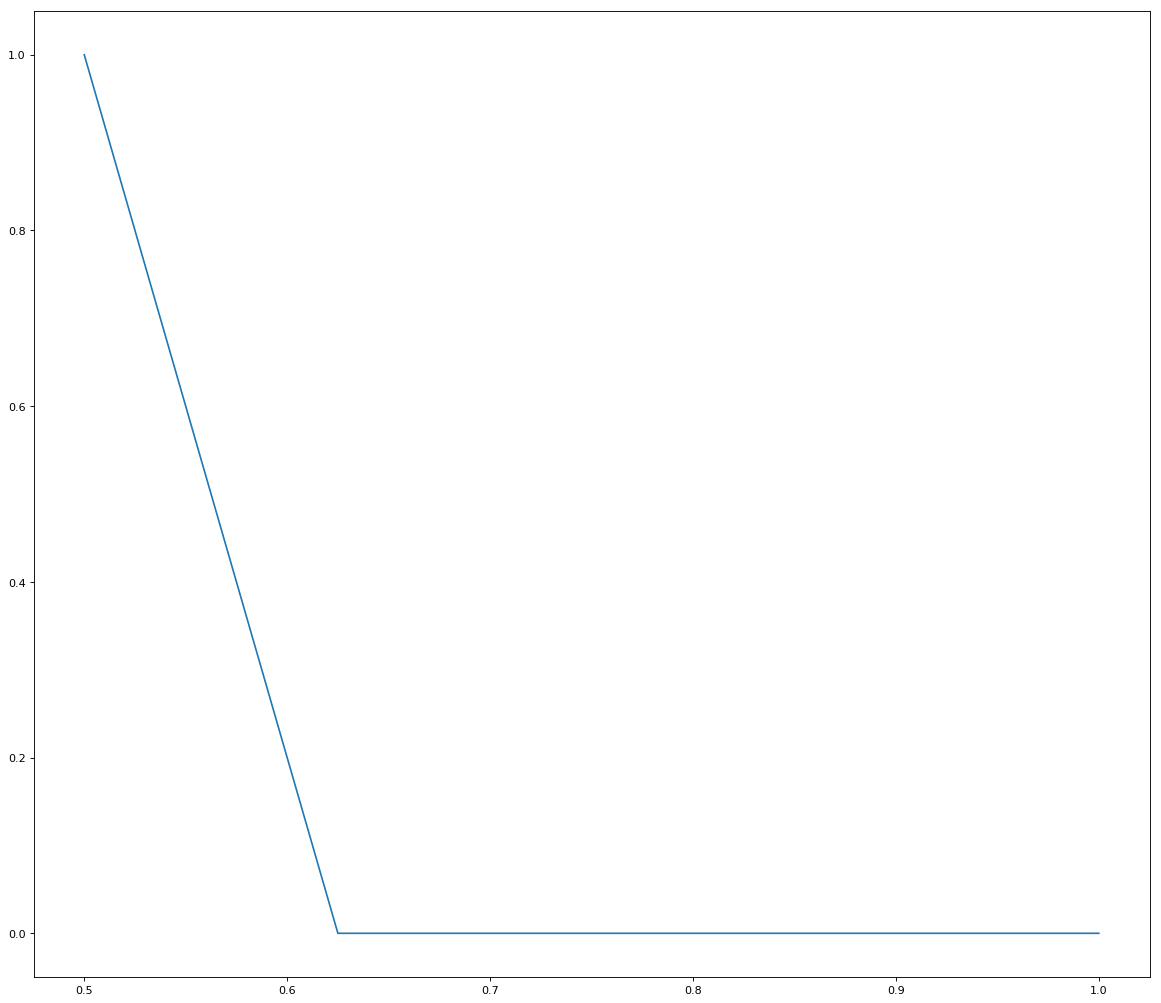

<Figure size 432x288 with 0 Axes>

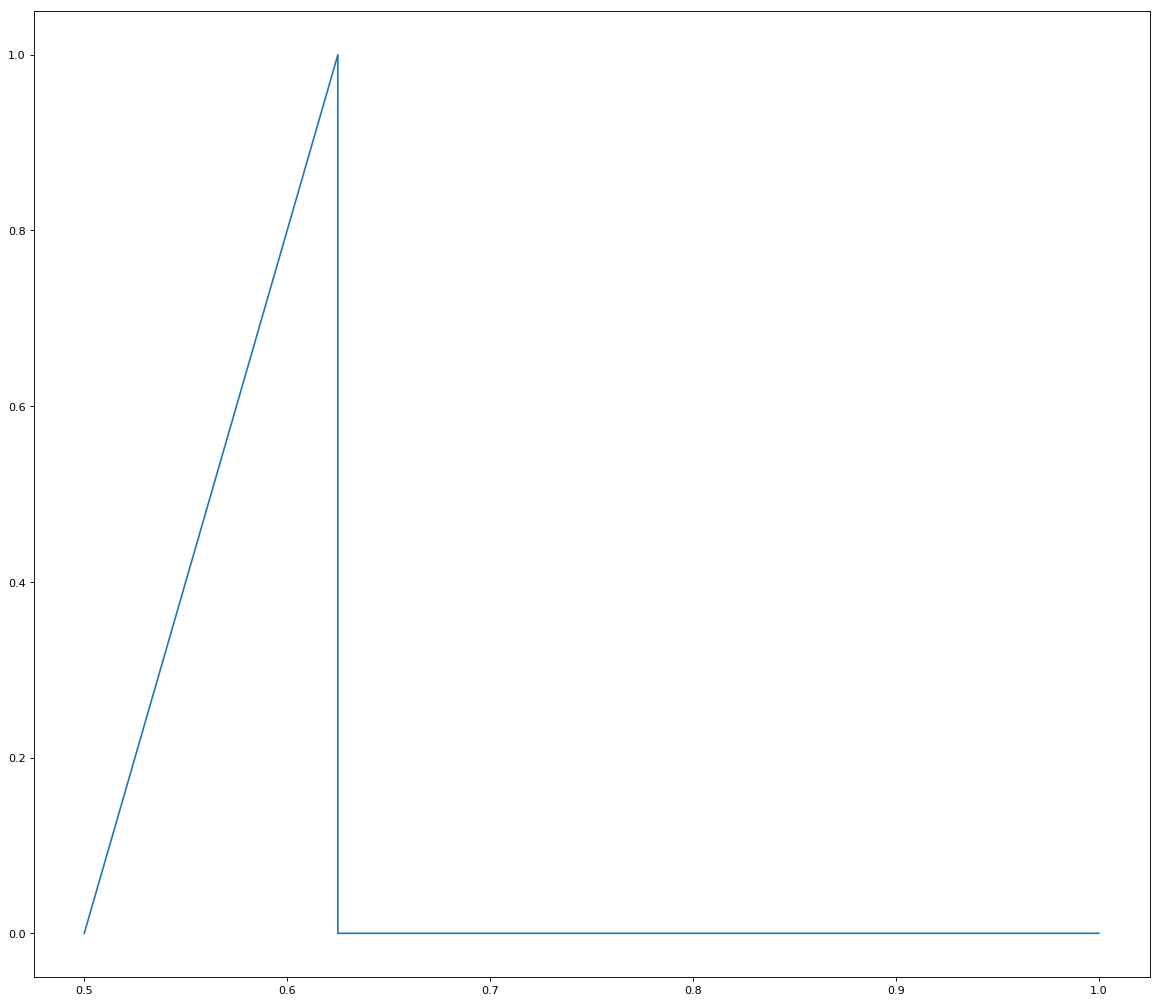

<Figure size 432x288 with 0 Axes>

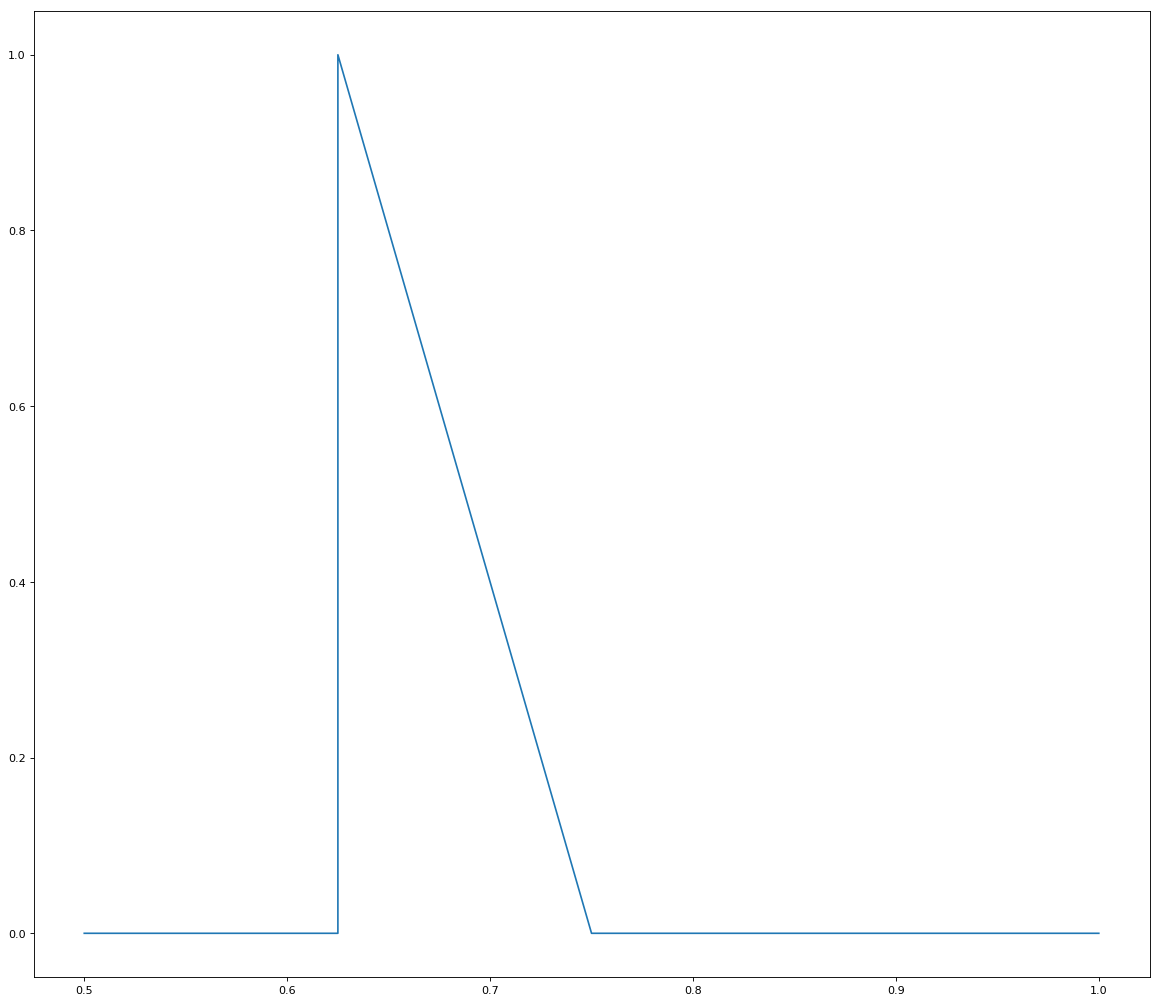

<Figure size 432x288 with 0 Axes>

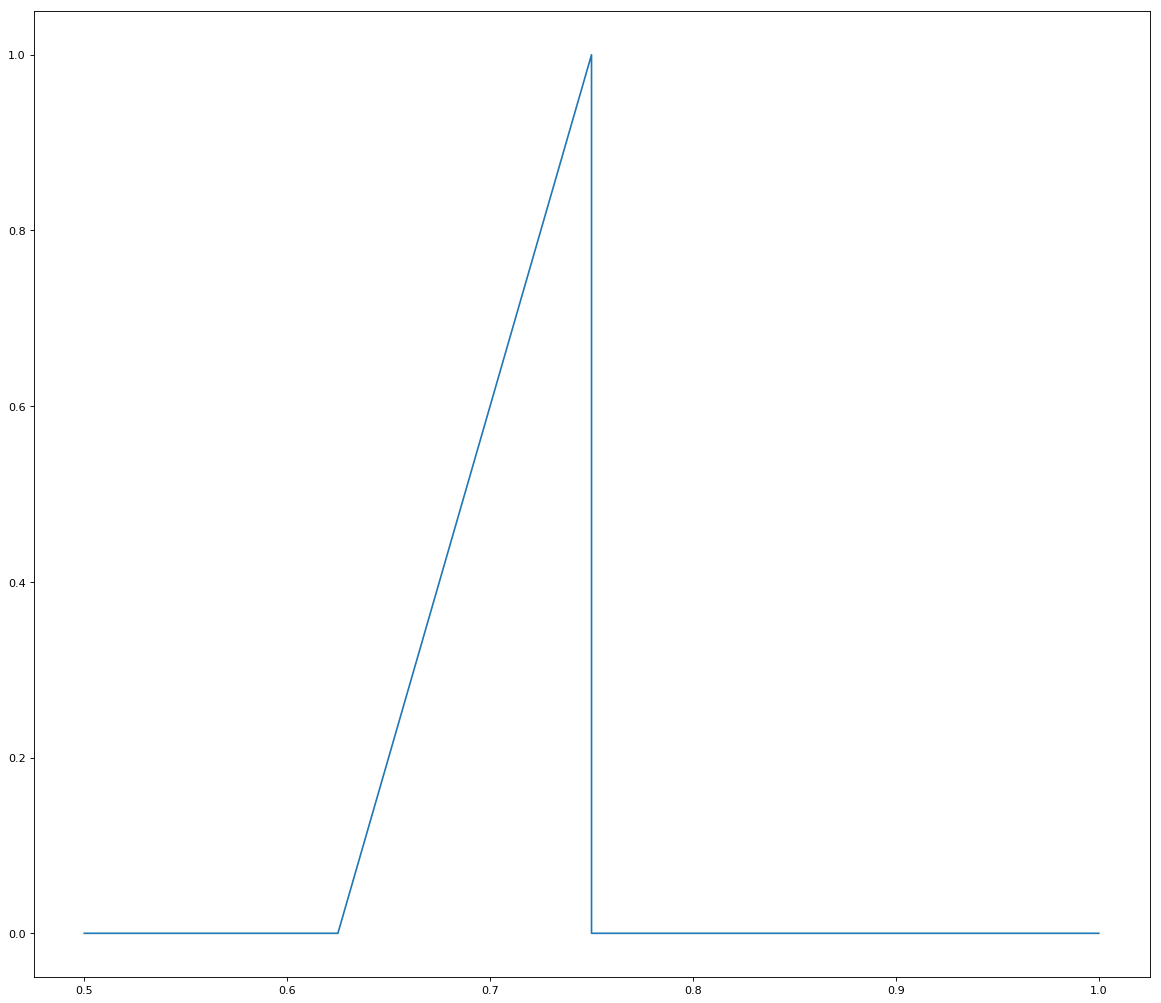

<Figure size 432x288 with 0 Axes>

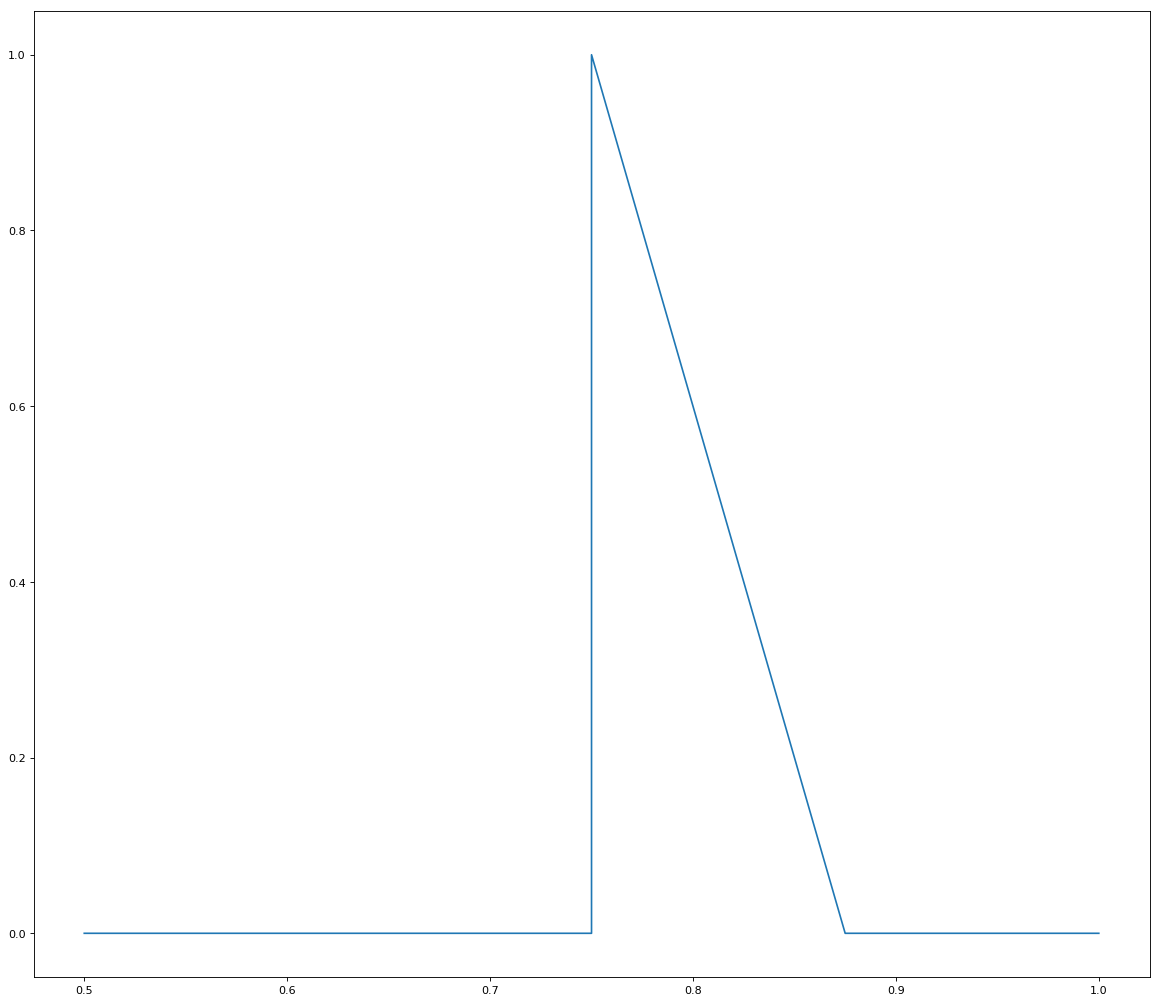

<Figure size 432x288 with 0 Axes>

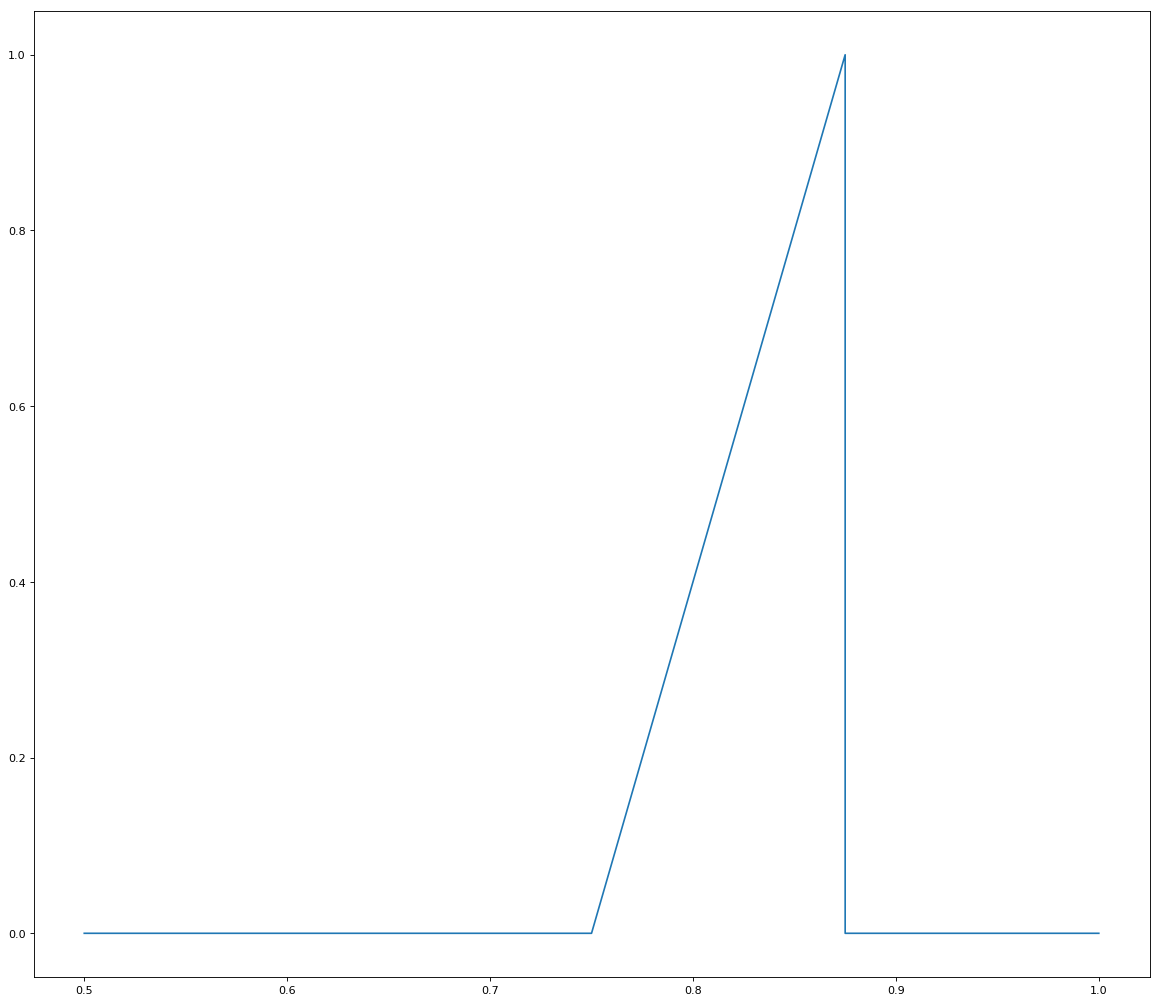

<Figure size 432x288 with 0 Axes>

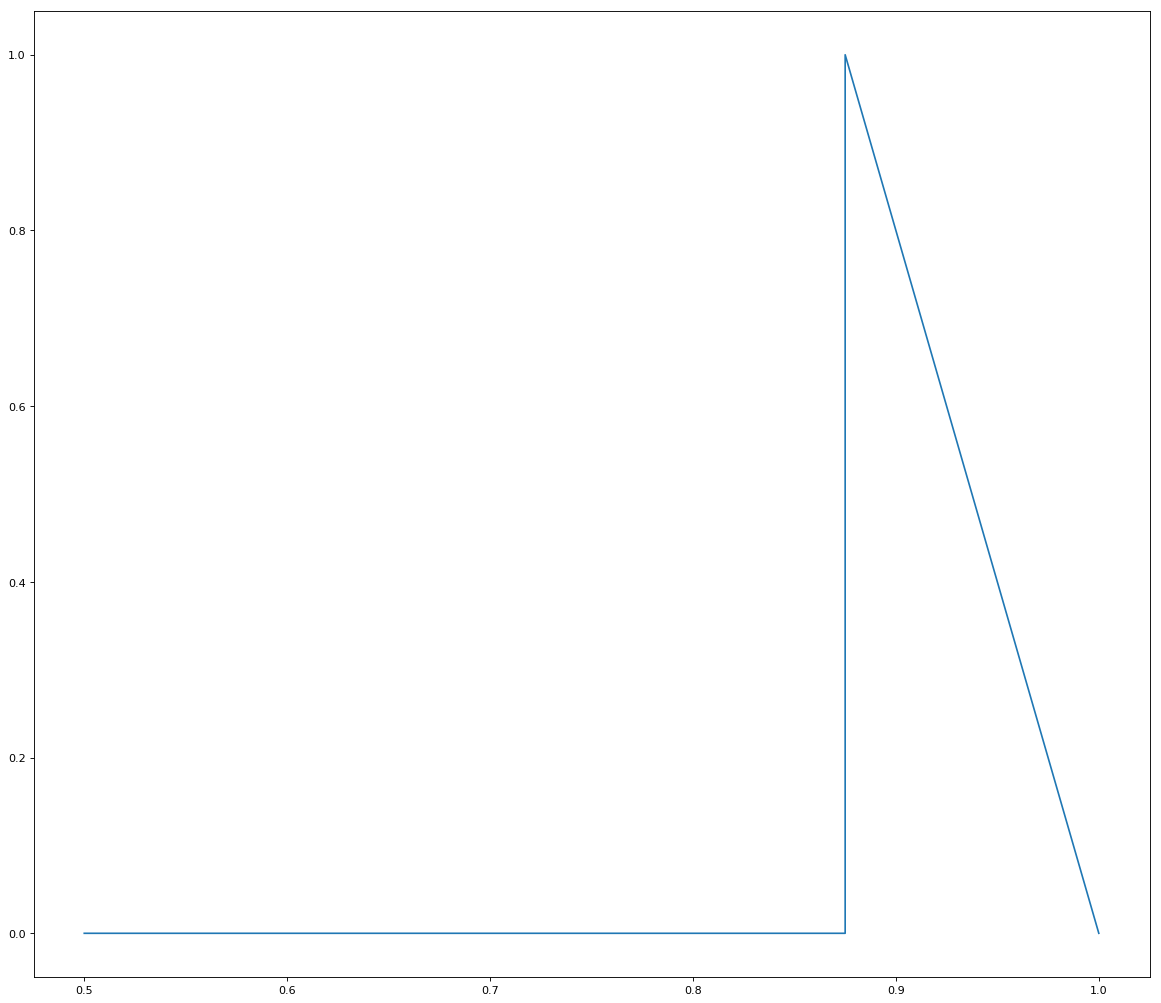

<Figure size 432x288 with 0 Axes>

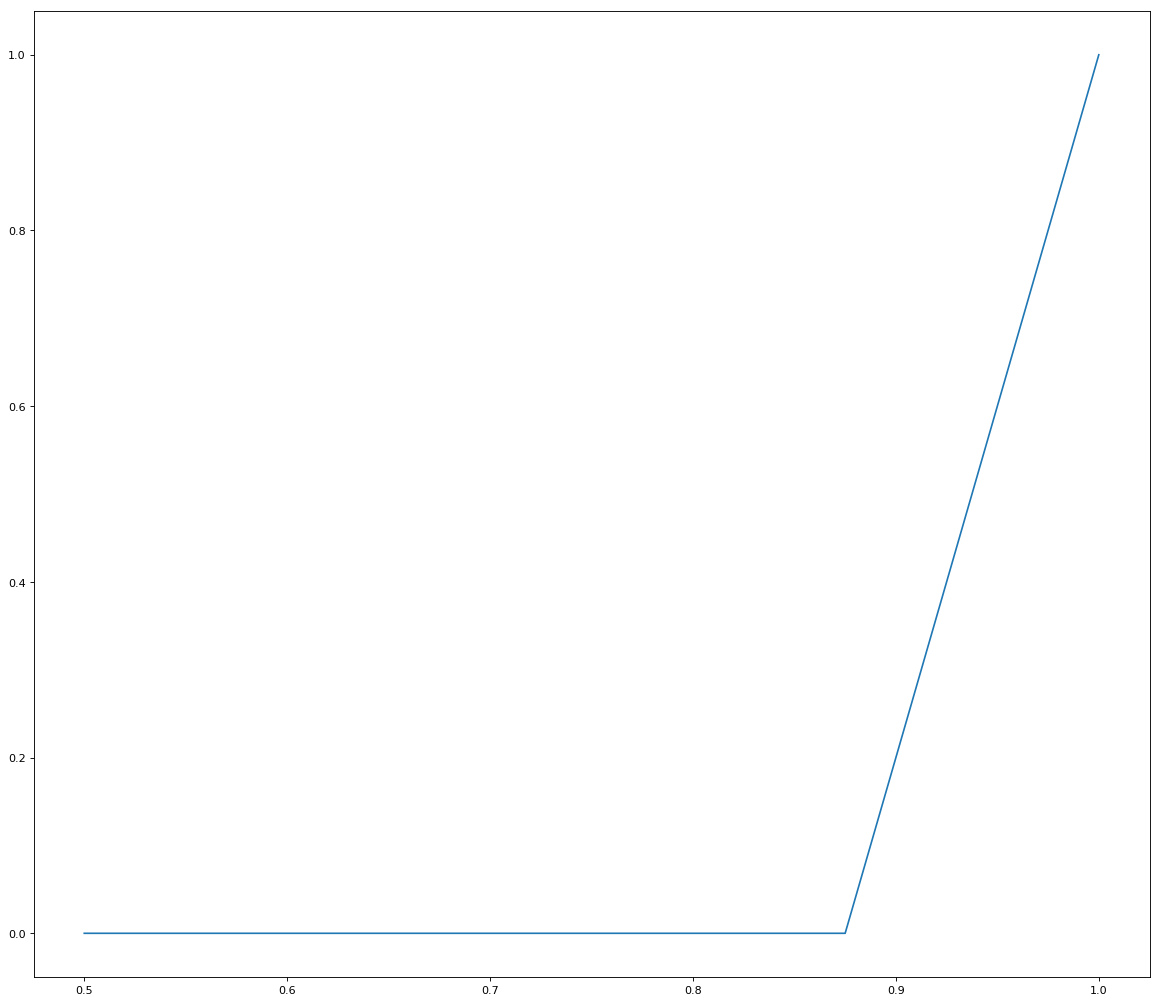

In [6]:
# Loop over all primal basis functions (nodes for FE).
for i in range(0, nr_nodes):
    # Create topology and geometry
    lower, upper, elems, node_nr = support(i, primalDegree, primalNelems, lbound, span)
    print(lower, upper, elems, node_nr)
    localDomain, localGeom = mesh.rectilinear([numpy.linspace(lower, upper, elems+1)]*ndims)
    intermediate = localDomain.refined
    fineDomain = intermediate.refined
    # Put geometry in namespace
    ns.x = localGeom
    # Create local bases
    #     Primal
    ns.coarseBasis = localDomain.basis('lagrange', degree=primalDegree)                 # corresponds to phi
    #     Adjoint
    ns.tB = ns.coarseBasis
    
    #print('CoarseBasis')
    #for testB in ns.tB:
    #    # plot solution
    #    ns.uAdj = testB
    #    plt.figure()
    #    bezier = fineDomain.sample('bezier', 9)
    #    x, uAdj = bezier.eval([ns.x, ns.uAdj])
    #    #x, analytical = bezier.eval([ns.x, ns.analytical])
    #    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #    plt.plot(x, uAdj)
    #    #plt.plot(x, analytical, 'r')
    #    # plt.ylim(-2,2)
    
    ns.tB = fineDomain.basis('discont', degree=(primalDegree*adjointDegree))            # corresponds to psi
    print('FineBasis')
    for testB in ns.tB:
        # plot solution
        ns.uAdj = testB
        plt.figure()
        bezier = fineDomain.sample('bezier', 9)
        x, uAdj = bezier.eval([ns.x, ns.uAdj])
        #x, analytical = bezier.eval([ns.x, ns.analytical])
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(x, uAdj)
        #plt.plot(x, analytical, 'r')
        # plt.ylim(-2,2)
        
    
    # Build adjoint solution function
    #ns.uAdj = 'adjointBasis_n ?lhsAdj_n'
    
    # Format primal basis function string (pbs) for integral expressions
    #     without derivative
    #pbs    = 'primalBasis_%s'   % (node_nr)
    #print('PBS is %s' % pbs)
    #pbsDer = 'primalBasis_%s,0' % (node_nr)
    #print('PBS is %s' % pbsDer)
    
    ####################################################################
    ###################### construct residual ##########################
    #-------------------------------------------------------------------
    # Element integrals
    # Diffusive part and RHS
    #resAdj = localDomain.integral('k uAdj_,0 adjointBasis_n,0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    #resAdj += localDomain.integral('-v uAdj_,0 adjointBasis_n' @ ns, geometry=ns.x, degree=5)
    # Advective part primal basis
    #resAdj += localDomain.integral('-v %s adjointBasis_n' % (pbsDer) @ ns, geometry=ns.x, degree=5)
    # SUPG stabilized part (will be added later)
    #resAdj -= localDomain.integral(' tau v adjointBasis_n,0 (k (uAdj_,0)_,0 + v (uAdj_,0 + %s) )' % (pbsDer) @ ns, geometry=ns.x, degree=5)

    # Interface integrals
    #if (adjointNelems > 1) or (elems > 1):
        # Diffusive part
        #    part one                      |
        #                                  v  minus might be necessary here because of jump definitions (likewise on second +)
     #   resAdj += localDomain.interfaces.integral(' [uAdj] n_0 k {adjointBasis_n,0} + beta k {uAdj_,0} [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        #    part two (stabilized)
     #   resAdj += localDomain.interfaces.integral(' tauA [uAdj] n_0 [adjointBasis_n] n_0' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
        # Advective part perturbation
     #   resAdj += localDomain.interfaces.integral('- v [uAdj] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' @ ns, geometry=ns.x, degree=5)
        # Advective part primal basis
     #   resAdj += localDomain.interfaces.integral('- v [%s] n_0 ({adjointBasis_n} - .5 C [adjointBasis_n] n_0)' % (pbs) @ ns, geometry=ns.x, degree=5)
    #else:
        # No interface integrals
     #   pass
        

    # Boundary integrals LHS
    #    part one
    #resAdj += localDomain.boundary.integral('- k uAdj adjointBasis_n,0 + beta k uAdj_,0 adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #    part two (stabilized)
    #resAdj += localDomain.boundary['left'].integral(' tauZero uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #resAdj += localDomain.boundary['right'].integral(' tauN uAdj adjointBasis_n ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)

    # Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
    # Diffusive part (keep an eye on the signs)
    #resAdj += localDomain.boundary['left'].integral(' ( k adjointBasis_n,0 - tauZero adjointBasis_n) gl ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #resAdj += localDomain.boundary['right'].integral(' ( k adjointBasis_n,0 - tauN adjointBasis_n) gr ' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part perturbation
    #resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + uAdj) + .5 C (gl - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + uAdj) + .5 C (gr - uAdj) n_0)' @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    # Advective part primal basis
    #resAdj += localDomain.boundary['left'].integral('v adjointBasis_n n_0 (0.5 (gl + %s) + .5 C (gl - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    #resAdj += localDomain.boundary['right'].integral('v adjointBasis_n n_0 (0.5 (gr + %s) + .5 C (gr - %s) n_0)' % (pbs, pbs) @ ns, geometry=ns.x, degree=primalDegree*adjointDegree*2)
    
    #-------------------------------------------------------------------
    ###################### construct residual ##########################
    ####################################################################
    
    
    # Solve system
    # find lhs such that res == 0 and substitute this lhs in the namespace
    # lhs = solver.solve_linear('lhs', res, constrain=cons)
    #lhsAdj = solver.solve_linear('lhsAdj', resAdj)
    #ns = ns(lhsAdj=lhsAdj)
    #print(lhsAdj)
    
    # plot solution
    #plt.figure()
    #bezier = localDomain.sample('bezier', 9)
    #x, uAdj = bezier.eval([ns.x, ns.uAdj])
    #x, analytical = bezier.eval([ns.x, ns.analytical])
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.plot(x, uAdj)
    #plt.plot(x, analytical, 'r')
    # plt.ylim(-2,2)